In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from scipy.signal import savgol_filter

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seawater

In [2]:
#get ctd files 
files = glob.glob('../Dissertation_projects/Data/CTD/DOWNCAST_RENAME/*.csv') 

#make vars 
stations = ['St.11', 'St.12', 'St.13', 'St.14-2', 'St.14', 'St.16-2',
            'St.16', 'St.2', 'St.4', 'St.6', 'St.7',
            'St.9', 'St.MK-2', 'St.MK', 'St.15', 'St.5B']
camps = ['GOM2021','GOM21FA', 'GOM22SP', 'GOM22SU']

select = camps[0] #0 to 2
selectstn = stations[0] #0 to 15

#pick out the vars you need
df1 = pd.read_csv(files[0])
cols_to_select = df1.columns.tolist()

#make the data frame 

frames = []

for f in files: 
    df = pd.read_csv(f)
    
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    
    camp = ID[1]
    station = ID[2]
    sample_id = ID[3]
    date = ID[4]
    
    maxd = df['Pressure [dbar]'].max()
    lat = df['latitude'].mean()
    lon = df['longitude'].mean()
    
    df_new = df.loc[:, cols_to_select]
    
    df_new['camp'] = camp
    df_new['station'] = station
    df_new['sample_id'] = sample_id
    df_new['date'] = date
    df_new['maxd'] = maxd
    df_new['lat'] = lat
    df_new['lon'] = lon
    
    frames.append(df_new)
    
ds = pd.concat(frames, axis=0)

ds['date_time'] = pd.to_datetime(ds['date'])
ds['dates'] = ds['date_time'].dt.date


ds_copy = ds['wetCDOM'].copy()
ds_copy.loc[ds_copy < -1] = np.nan
ds_copy.loc[ds_copy > 125] = np.nan
ds = pd.merge(ds, ds_copy, left_index=True, right_index=True, how='outer')
ds = ds.rename(columns={'wetCDOM_x': 'wetCDOM', 'wetCDOM_y': 'wetCDOM_clean'})

# get the unique values for each group
station_vals = ds['station'].unique()
camp_vals = ds['camp'].unique()


C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\2492785790.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ds['date_time'] = pd.to_datetime(ds['date'])


In [3]:

ds['ox_uM'] = ds['sbeox0Mg/L'] / 1000 * 32 * 1000 

ds.columns


Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'date_time', 'dates', 'wetCDOM_clean', 'ox_uM'],
      dtype='object')

In [4]:


ds['Ts'] = (298.15 - ds['t090C']) / (273.15 + ds['t090C'])
ds['Ts'] = np.log(ds['Ts'] ) 


ds['density_kg_m3'] = seawater.dens(ds['sal00'], ds['t090C'], ds['Pressure [dbar]'])  # density at specified pressure (in kg/m^3)
ds['density_kg_l'] = ds['density_kg_m3'] / 1000

ds['ox_umol_kg'] = ds['ox_uM'] / ds['density_kg_l']

con1 = 5.80871
con2 = 3.20291
con3 = 4.17887 
con4 = 5.10006 
con5 = 9.86643e-2
con6 = 3.80369 

cof1 = -7.01577e-3
cof2 = -7.70028e-3
cof3 = -1.13864e-2
cof4 = -9.51519e-3
cof5 = -2.75915e-7

ds['sal'] = ds['sal00']

#as per book 
ds['ox_sat'] = con1+ds['Ts']*con2+(ds['Ts']**2)*con3+(ds['Ts']**3)*con4+(ds['Ts']**4)*con5+(ds['Ts']**5)*con6
ds['ox_sat'] = ds['ox_sat'] + ds['sal']*(cof1 + cof2*ds['Ts'] + cof3*ds['Ts']**2 + cof4*ds['Ts']**3 + cof5*ds['sal']**2)
ds['ox_sat'] = np.exp(ds['ox_sat'])

ds['aou'] = ds['ox_sat'] - ds['ox_umol_kg'] 
ds.columns


Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'date_time', 'dates', 'wetCDOM_clean', 'ox_uM',
       'Ts', 'density_kg_m3', 'density_kg_l', 'ox_umol_kg', 'sal', 'ox_sat',
       'aou'],
      dtype='object')

In [5]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

df_doc = df_doc.drop(222101, axis=0)
df_doc = df_doc.drop(212211, axis=0)


###################################################

#get WC data sets 
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

codes = df_doc_wc['code'].unique()

df_doc_wc_plot = df_doc_wc[df_doc_wc['code'].isin(codes)]

max_depth_per_code = df_doc_wc_plot.groupby('code')['Depth'].max().reset_index()
df_doc_wc_plot = pd.merge(df_doc_wc_plot, max_depth_per_code, on='code', suffixes=('', '_max'))
df_doc_wc_plot = df_doc_wc_plot[df_doc_wc_plot['Depth'] == df_doc_wc_plot['Depth_max']]
df_doc_wc_plot.drop(columns=['Depth_max'], inplace=True)



#mean_doc = df_doc_wc_plot.groupby('code')['NPOC_uM'].mean().reset_index()
#mean_tn = df_doc_wc_plot.groupby('code')['TN_uM'].mean().reset_index()
#std_doc = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mesuan().reset_index()
#stc_tn = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mean().reset_index()

df_doc_wc_plot['Depth_sample'] = df_doc_wc_plot['Depth']
df_doc_wc_plot['Depth'] = -0.5

# Calculate the mean of "NPOC_uM", "TN_uM", and "Depth" for each group in 'code'
df_doc_wc_plot = df_doc_wc_plot.groupby('code').agg({'NPOC_uM': 'mean', 'TN_uM': 'mean', 'Depth': 'mean', 'NPOC_uM_std': 'sum', 'TN_uM_std': 'sum'}).reset_index()


# Display the result dataframe
df_doc_wc_plot.index = df_doc_wc_plot['code']
df_doc_wc_plot

code     NPOC_uM       TN_uM  Depth  NPOC_uM_std  \
code                                                                           
St.11_GOM2021      St.11_GOM2021  106.625000   35.994643   -0.5     1.704837   
St.11_GOM21FA      St.11_GOM21FA   48.339583   28.237500   -0.5     1.027276   
St.11_GOM22SU      St.11_GOM22SU   38.945833   24.207143   -0.5     0.277769   
St.12_GOM21FA      St.12_GOM21FA   48.875000   28.782143   -0.5     1.038654   
St.12_GOM22SU      St.12_GOM22SU   65.222917   28.582143   -0.5     0.517690   
St.13_GOM2021      St.13_GOM2021   55.552083   24.010714   -0.5     0.731472   
St.13_GOM21FA      St.13_GOM21FA   52.391440   29.832143   -0.5     0.639296   
St.13_GOM22SP      St.13_GOM22SP   64.608333   28.153571   -0.5     0.425819   
St.13_GOM22SU      St.13_GOM22SU   26.844481   52.706462   -0.5    54.817104   
St.14.5_GOM21FA  St.14.5_GOM21FA   64.250000   13.439286   -0.5     0.682696   
St.14_GOM2021      St.14_GOM2021   70.231250   12.898214   -0.5     4.121912   
St.14_GOM21FA      St.14_GOM21FA   60.520833   13.425000   -0.5     0.643071   
St.14_GOM22SP      St.14_GOM22SP  105.791667   14.398214   -0.5     1.394499   
St.14_GOM22SU      St.14_GOM22SU   62.256250   12.291071   -0.5     0.494143   
St.15_GOM2021      St.15_GOM2021   63.075000   25.310714   -0.5     0.830528   
St.15_GOM21FA      St.15_GOM21FA   49.239583   21.676786   -0.5     1.046402   
St.15_GOM22SP      St.15_GOM22SP   52.512500   24.067857   -0.5     0.371604   
St.15_GOM22SU      St.15_GOM22SU   53.250000   21.685714   -0.5     0.379790   
St.16-2_GOM21FA  St.16-2_GOM21FA   95.875476   12.303571   -0.5     2.339804   
St.16_GOM2021      St.16_GOM2021  122.979167   16.582143   -0.5     1.619305   
St.16_GOM21FA      St.16_GOM21FA   71.752083    9.250000   -0.5     1.524820   
St.16_GOM22SP      St.16_GOM22SP   90.520833   15.325000   -0.5     1.281139   
St.16_GOM22SU      St.16_GOM22SU   74.572917    7.725357   -0.5     1.063738   
St.2_GOM2021        St.2_GOM2021   81.102083   10.275000   -0.5     1.067897   
St.2_GOM21FA        St.2_GOM21FA   43.850000    9.646250   -0.5     0.931867   
St.2_GOM22SP        St.2_GOM22SP  110.500000   12.305357   -0.5     1.456562   
St.2_GOM22SU        St.2_GOM22SU    7.584151   73.757572   -0.5   115.066815   
St.4_GOM2021        St.4_GOM2021   85.760417   17.526786   -0.5     5.033328   
St.4_GOM21FA        St.4_GOM21FA  123.479167    9.289286   -0.5     2.399646   
St.4_GOM22SP        St.4_GOM22SP  116.458333    7.412321   -0.5     0.947552   
St.4_GOM22SU        St.4_GOM22SU   12.812491   77.831981   -0.5    80.948779   
St.5B_GOM2021      St.5B_GOM2021  113.666667    0.208393   -0.5     6.671161   
St.5B_GOM21FA      St.5B_GOM21FA  128.395833   10.130357   -0.5     2.495194   
St.5B_GOM22SP      St.5B_GOM22SP  115.666667    8.373214   -0.5     1.637027   
St.5B_GOM22SU      St.5B_GOM22SU   21.962132  117.961671   -0.5   122.685471   
St.6_GOM21FA        St.6_GOM21FA  122.166667    9.416071   -0.5     2.374139   
St.7_GOM2021        St.7_GOM2021  116.520833   20.562500   -0.5     1.863062   
St.7_GOM21FA        St.7_GOM21FA   77.837500    8.542857   -0.5     0.827072   
St.7_GOM22SP        St.7_GOM22SP  101.635417   11.596429   -0.5     1.438443   
St.7_GOM22SU        St.7_GOM22SU   94.354167   18.792857   -0.5     1.345905   
St.9_GOM2021        St.9_GOM2021   73.675000   12.273214   -0.5     4.324028   
St.9_GOM21FA        St.9_GOM21FA   67.102778   13.805952   -0.5     2.139025   
St.9_GOM22SP        St.9_GOM22SP   72.154167    6.865357   -0.5     0.572705   
St.9_GOM22SU        St.9_GOM22SU   52.858333   11.676786   -0.5     0.622983   
St.MK-2_GOM21FA  St.MK-2_GOM21FA  114.375000    8.655357   -0.5     2.430610   
St.MK_GOM2021      St.MK_GOM2021  101.895833   13.482143   -0.5     5.980325   
St.MK_GOM21FA      St.MK_GOM21FA  104.270833   12.792857   -0.5     2.026359   
St.MK_GOM22SP      St.MK_GOM22SP  128.312500   13.008929   -0.5     1.854758   
St.MK_GOM22SU      St.MK_GOM

In [6]:
#get WC data sets 
df_doc_wc_surf = df_doc[df_doc['Type'] == 'WC']

codes = df_doc_wc_surf['code'].unique()

df_doc_wc_surf = df_doc_wc_surf[df_doc_wc_surf['code'].isin(codes)]

min_depth_per_code = df_doc_wc_surf.groupby('code')['Depth'].min().reset_index()
df_doc_wc_surf = pd.merge(df_doc_wc_surf, min_depth_per_code, on='code', suffixes=('', '_min'))
df_doc_wc_surf = df_doc_wc_surf[df_doc_wc_surf['Depth'] == df_doc_wc_surf['Depth_min']]
df_doc_wc_surf.drop(columns=['Depth_min'], inplace=True)



#mean_doc = df_doc_wc_plot.groupby('code')['NPOC_uM'].mean().reset_index()
#mean_tn = df_doc_wc_plot.groupby('code')['TN_uM'].mean().reset_index()
#std_doc = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mesuan().reset_index()
#stc_tn = df_doc_wc_plot.groupby('code')['NPOC_uM_std'].mean().reset_index()

df_doc_wc_surf['Depth_sample'] = df_doc_wc_surf['Depth']
df_doc_wc_surf['Depth'] = 0

# Calculate the mean of "NPOC_uM", "TN_uM", and "Depth" for each group in 'code'
df_doc_wc_surf = df_doc_wc_surf.groupby('code').agg({'NPOC_uM': 'mean', 'TN_uM': 'mean', 'Depth': 'mean', 'NPOC_uM_std': 'sum', 'TN_uM_std': 'sum'}).reset_index()


# Display the result dataframe
df_doc_wc_surf.index = df_doc_wc_surf['code']
df_doc_wc_surf['NPOC_uM_surf'] = df_doc_wc_surf['NPOC_uM']
df_doc_wc_surf

df_doc_wc_plot['NPOC_uM_surf'] = df_doc_wc_surf['NPOC_uM']
df_doc_wc_plot

code     NPOC_uM       TN_uM  Depth  NPOC_uM_std  \
code                                                                           
St.11_GOM2021      St.11_GOM2021  106.625000   35.994643   -0.5     1.704837   
St.11_GOM21FA      St.11_GOM21FA   48.339583   28.237500   -0.5     1.027276   
St.11_GOM22SU      St.11_GOM22SU   38.945833   24.207143   -0.5     0.277769   
St.12_GOM21FA      St.12_GOM21FA   48.875000   28.782143   -0.5     1.038654   
St.12_GOM22SU      St.12_GOM22SU   65.222917   28.582143   -0.5     0.517690   
St.13_GOM2021      St.13_GOM2021   55.552083   24.010714   -0.5     0.731472   
St.13_GOM21FA      St.13_GOM21FA   52.391440   29.832143   -0.5     0.639296   
St.13_GOM22SP      St.13_GOM22SP   64.608333   28.153571   -0.5     0.425819   
St.13_GOM22SU      St.13_GOM22SU   26.844481   52.706462   -0.5    54.817104   
St.14.5_GOM21FA  St.14.5_GOM21FA   64.250000   13.439286   -0.5     0.682696   
St.14_GOM2021      St.14_GOM2021   70.231250   12.898214   -0.5     4.121912   
St.14_GOM21FA      St.14_GOM21FA   60.520833   13.425000   -0.5     0.643071   
St.14_GOM22SP      St.14_GOM22SP  105.791667   14.398214   -0.5     1.394499   
St.14_GOM22SU      St.14_GOM22SU   62.256250   12.291071   -0.5     0.494143   
St.15_GOM2021      St.15_GOM2021   63.075000   25.310714   -0.5     0.830528   
St.15_GOM21FA      St.15_GOM21FA   49.239583   21.676786   -0.5     1.046402   
St.15_GOM22SP      St.15_GOM22SP   52.512500   24.067857   -0.5     0.371604   
St.15_GOM22SU      St.15_GOM22SU   53.250000   21.685714   -0.5     0.379790   
St.16-2_GOM21FA  St.16-2_GOM21FA   95.875476   12.303571   -0.5     2.339804   
St.16_GOM2021      St.16_GOM2021  122.979167   16.582143   -0.5     1.619305   
St.16_GOM21FA      St.16_GOM21FA   71.752083    9.250000   -0.5     1.524820   
St.16_GOM22SP      St.16_GOM22SP   90.520833   15.325000   -0.5     1.281139   
St.16_GOM22SU      St.16_GOM22SU   74.572917    7.725357   -0.5     1.063738   
St.2_GOM2021        St.2_GOM2021   81.102083   10.275000   -0.5     1.067897   
St.2_GOM21FA        St.2_GOM21FA   43.850000    9.646250   -0.5     0.931867   
St.2_GOM22SP        St.2_GOM22SP  110.500000   12.305357   -0.5     1.456562   
St.2_GOM22SU        St.2_GOM22SU    7.584151   73.757572   -0.5   115.066815   
St.4_GOM2021        St.4_GOM2021   85.760417   17.526786   -0.5     5.033328   
St.4_GOM21FA        St.4_GOM21FA  123.479167    9.289286   -0.5     2.399646   
St.4_GOM22SP        St.4_GOM22SP  116.458333    7.412321   -0.5     0.947552   
St.4_GOM22SU        St.4_GOM22SU   12.812491   77.831981   -0.5    80.948779   
St.5B_GOM2021      St.5B_GOM2021  113.666667    0.208393   -0.5     6.671161   
St.5B_GOM21FA      St.5B_GOM21FA  128.395833   10.130357   -0.5     2.495194   
St.5B_GOM22SP      St.5B_GOM22SP  115.666667    8.373214   -0.5     1.637027   
St.5B_GOM22SU      St.5B_GOM22SU   21.962132  117.961671   -0.5   122.685471   
St.6_GOM21FA        St.6_GOM21FA  122.166667    9.416071   -0.5     2.374139   
St.7_GOM2021        St.7_GOM2021  116.520833   20.562500   -0.5     1.863062   
St.7_GOM21FA        St.7_GOM21FA   77.837500    8.542857   -0.5     0.827072   
St.7_GOM22SP        St.7_GOM22SP  101.635417   11.596429   -0.5     1.438443   
St.7_GOM22SU        St.7_GOM22SU   94.354167   18.792857   -0.5     1.345905   
St.9_GOM2021        St.9_GOM2021   73.675000   12.273214   -0.5     4.324028   
St.9_GOM21FA        St.9_GOM21FA   67.102778   13.805952   -0.5     2.139025   
St.9_GOM22SP        St.9_GOM22SP   72.154167    6.865357   -0.5     0.572705   
St.9_GOM22SU        St.9_GOM22SU   52.858333   11.676786   -0.5     0.622983   
St.MK-2_GOM21FA  St.MK-2_GOM21FA  114.375000    8.655357   -0.5     2.430610   
St.MK_GOM2021      St.MK_GOM2021  101.895833   13.482143   -0.5     5.980325   
St.MK_GOM21FA      St.MK_GOM21FA  104.270833   12.792857   -0.5     2.026359   
St.MK_GOM22SP      St.MK_GOM22SP  128.312500   13.008929   -0.5     1.854758   
St.MK_GOM22SU      St.MK_GOM

In [7]:
df_o2 = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/O2_Summary_Stats.csv', sep=',', index_col=0)

df = df_o2.join(df_doc_wc_plot)
df

camp  station        date  Max_pressure  \
code                                                          
St.11_GOM2021    GOM2021    St.11  2021-07-25       946.986   
St.13_GOM2021    GOM2021    St.13  2021-07-21       321.519   
St.14_GOM2021    GOM2021    St.14  2021-07-19        91.278   
St.15_GOM2021    GOM2021    St.15  2021-07-23       287.295   
St.16_GOM2021    GOM2021    St.16  2021-07-24        61.804   
St.2_GOM2021     GOM2021     St.2  2021-07-22        63.413   
St.4_GOM2021     GOM2021     St.4  2021-07-17        17.437   
St.5B_GOM2021    GOM2021    St.5B  2021-07-16        12.856   
St.7_GOM2021     GOM2021     St.7  2021-07-26        39.529   
St.9_GOM2021     GOM2021     St.9  2021-07-20        79.028   
St.MK_GOM2021    GOM2021    St.MK  2021-07-15        16.981   
St.ML_GOM2021    GOM2021    St.ML  2021-07-27        14.595   
St.11_GOM21FA    GOM21FA    St.11  2021-11-10       916.966   
St.12_GOM21FA    GOM21FA    St.12  2021-11-09       960.512   
St.13_GOM21FA    GOM21FA    St.13  2021-11-07       448.876   
St.14_GOM21FA    GOM21FA    St.14  2021-10-31        88.896   
St.14.5_GOM21FA  GOM21FA  St.14.5  2021-11-01       104.344   
St.15_GOM21FA    GOM21FA    St.15  2021-11-02       263.293   
St.16_GOM21FA    GOM21FA    St.16  2021-11-08        58.940   
St.16-2_GOM21FA  GOM21FA  St.16-2  2021-11-12        15.517   
St.2_GOM21FA     GOM21FA     St.2  2021-11-02        62.458   
St.4_GOM21FA     GOM21FA     St.4  2021-10-26        17.006   
St.5B_GOM21FA    GOM21FA    St.5B  2021-10-25        12.869   
St.6_GOM21FA     GOM21FA     St.6  2021-10-25        13.849   
St.7_GOM21FA     GOM21FA     St.7  2021-10-31        38.371   
St.9_GOM21FA     GOM21FA     St.9  2021-11-01        81.090   
St.MK_GOM21FA    GOM21FA    St.MK  2021-10-27        17.149   
St.MK-2_GOM21FA  GOM21FA  St.MK-2  2021-10-30        13.611   
St.13_GOM22SP    GOM22SP    St.13  2022-04-18       557.668   
St.14_GOM22SP    GOM22SP    St.14  2022-04-09        88.922   
St.15_GOM22SP    GOM22SP    St.15  2022-04-16       263.450   
St.16_GOM22SP    GOM22SP    St.16  2022-04-11        57.412   
St.2_GOM22SP     GOM22SP     St.2  2022-04-17        63.432   
St.4_GOM22SP     GOM22SP     St.4  2022-04-20        16.450   
St.5B_GOM22SP    GOM22SP    St.5B  2022-04-14        13.664   
St.7_GOM22SP     GOM22SP     St.7  2022-04-10        39.548   
St.9_GOM22SP     GOM22SP     St.9  2022-04-16        79.039   
St.MK_GOM22SP    GOM22SP    St.MK  2022-04-19        17.800   
St.11_GOM22SU    GOM22SU    St.11  2022-07-22       945.291   
St.12_GOM22SU    GOM22SU    St.12  2022-07-21       996.658   
St.13_GOM22SU    GOM22SU    St.13  2022-07-18       487.498   
St.14_GOM22SU    GOM22SU    St.14  2022-07-16        86.455   
St.15_GOM22SU    GOM22SU    St.15  2022-07-15       266.624   
St.16_GOM22SU    GOM22SU    St.16  2022-07-20        57.999   
St.2_GOM22SU     GOM22SU     St.2  2022-07-19        62.421   
St.4_GOM22SU     GOM22SU     St.4  2022-07-10        17.075   
St.5B_GOM22SU    GOM22SU    St.5B  2022-07-10        12.409   
St.7_GOM22SU     GOM22SU     St.7  2022-07-12        41.135   
St.9_GOM22SU     GOM22SU     St.9  2022-07-17        79.973   
St.MK_GOM22SU    GOM22SU    St.MK  2022-07-23        17.611   

                 Pressure_dbar_surface  O2_mgL_surface  latitude_surface  \
code                                                                       
St.11_GOM2021                    2.076          7.3366          28.21678   
St.13_GOM2021                    2.283          6.2980          28.53696   
St.14_GOM2021                    1.829          6.3473          28.72514   
St.15_GOM2021                    2.191          9.0433          28.94254   
St.16_GOM2021                    1.277          7.4623          28.88042   
St.2_GOM2021                     2.074          6.8821          28.89964   
St.4_GOM2021                     1.145          8.2318          28.79886   
St.5B_GOM2021                    1.505          7.6929     

In [8]:
df_doc_wc_plot_2 = df_doc_wc_plot
df_doc_wc_plot_2['NPOC_uM_bottom_water'] = df_doc_wc_plot_2['NPOC_uM']
df_doc_wc_plot_2['TN_uM_bottom_water'] = df_doc_wc_plot_2['TN_uM']
df_doc_wc_plot_2 = df_doc_wc_plot_2.drop(columns=['code', 'NPOC_uM','TN_uM', 'Depth', 'NPOC_uM_std', 'TN_uM_std'])

df_doc_wc_plot_2.to_csv('../Dissertation_projects/Data/Stats_data_sets/bottom_water_DOC.csv')
df_doc_wc_plot_2

NPOC_uM_surf  NPOC_uM_bottom_water  TN_uM_bottom_water
code                                                                   
St.11_GOM2021      104.270833            106.625000           35.994643
St.11_GOM21FA       74.391667             48.339583           28.237500
St.11_GOM22SU      141.166667             38.945833           24.207143
St.12_GOM21FA       85.791667             48.875000           28.782143
St.12_GOM22SU      224.666667             65.222917           28.582143
St.13_GOM2021       96.166667             55.552083           24.010714
St.13_GOM21FA       87.548288             52.391440           29.832143
St.13_GOM22SP      120.437500             64.608333           28.153571
St.13_GOM22SU       10.402342             26.844481           52.706462
St.14.5_GOM21FA    133.000000             64.250000           13.439286
St.14_GOM2021       96.979167             70.231250           12.898214
St.14_GOM21FA      140.125000             60.520833           13.425000
St.14_GOM22SP      151.375000            105.791667           14.398214
St.14_GOM22SU      199.916667             62.256250           12.291071
St.15_GOM2021      147.333333             63.075000           25.310714
St.15_GOM21FA       93.679167             49.239583           21.676786
St.15_GOM22SP      120.145833             52.512500           24.067857
St.15_GOM22SU      216.666667             53.250000           21.685714
St.16-2_GOM21FA    147.224674             95.875476           12.303571
St.16_GOM2021      252.500000            122.979167           16.582143
St.16_GOM21FA      143.125000             71.752083            9.250000
St.16_GOM22SP      103.612500             90.520833           15.325000
St.16_GOM22SU      214.708333             74.572917            7.725357
St.2_GOM2021       198.770833             81.102083           10.275000
St.2_GOM21FA       141.791667             43.850000            9.646250
St.2_GOM22SP       184.250000            110.500000           12.305357
St.2_GOM22SU        95.103841              7.584151           73.757572
St.4_GOM2021       111.750000             85.760417           17.526786
St.4_GOM21FA       136.520833            123.479167            9.289286
St.4_GOM22SP       117.791667            116.458333            7.412321
St.4_GOM22SU        12.066804             12.812491           77.831981
St.5B_GOM2021      131.250000            113.666667            0.208393
St.5B_GOM21FA      136.750000            128.395833           10.130357
St.5B_GOM22SP       97.718750            115.666667            8.373214
St.5B_GOM22SU       12.162056             21.962132          117.961671
St.6_GOM21FA       150.750000            122.166667            9.416071
St.7_GOM2021       211.625000            116.520833           20.562500
St.7_GOM21FA        72.585417             77.837500            8.542857
St.7_GOM22SP        82.925000            101.635417           11.596429
St.7_GOM22SU       214.208333             94.354167           18.792857
St.9_GOM2021        90.354167             73.675000           12.273214
St.9_GOM21FA       133.291667             67.102778           13.805952
St.9_GOM22SP       160.229167             72.154167            6.865357
St.9_GOM22SU       176.583333             52.858333           11.676786
St.MK-2_GOM21FA    133.916667            114.375000            8.655357
St.MK_GOM2021      200.041667            101.895833           13.482143
St.MK_GOM21FA      166.416667            104.270833           12.792857
St.MK_GOM22SP      133.000000            128.312500           13.008929
St.MK_GOM22SU       93.791667            101.305556           12.150000
St.ML_GOM2021      202.812500            134.312500           21.325000

###DEFINITIONS

In [9]:
lat_top=30
lat_bot=28
lon_left=-91.5
lon_rigth=-88.75
extent=[lon_left, lon_rigth, lat_bot, lat_top]

# set resolution of the features in map: '10m', '50m', or '110m'.  
# If you do this the first time it will take a while downloading the coastline 
# and other features. In the future it will be faster
res = '10m'

def plot_mapbase(extent, ax=None, res='10m', projection=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(10,5)) # set fig size
        ax = fig.add_subplot(111, projection=projection)
        
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='lightgrey', 
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue',
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

def map_O2(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.oxy,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=300,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()
    



In [10]:


def map_doc(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.turbid,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=150,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()
    

def map_doc(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.turbid,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=250,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()


In [11]:
def map_temp(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.thermal,
                                   s=200,
                                   vmin=0,  # Set global min and max for colormap
                                   vmax=31,
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()
    

In [12]:
def map_sal(data_f, topic, cb_name):
    camps = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.ravel()  # Flatten the 2x2 grid to access each subplot with a single index
    for i, camp in enumerate(camps):
        df_subset = data_f[data_f['camp'] == camp].dropna(subset=[topic])    
        plot_mapbase(extent, ax=axes[i])
        mappable = axes[i].scatter(df_subset['longitude_bottom'], df_subset['latitude_bottom'],
                                   c=df_subset[topic],
                                   edgecolor='k',
                                   cmap=cmo.haline,
                                   s=200,
                                   vmin=data_f[topic].min(),  # Set global min and max for colormap
                                   vmax=data_f[topic].max(),
                                   transform=ccrs.PlateCarree())
    
        label_map = {
            'GOM2021': 'Summer 2021',
            'GOM21FA': 'Fall 2021',
            'GOM22SP': 'Spring 2022',
            'GOM22SU': 'Summer 2022'
        }
    
        axes[i].set_title(label_map[camp], size = 20)
    
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb = fig.colorbar(mappable, cax=cbar_ax)
    cb.set_label(cb_name, size=20, color='black')
    cb.ax.tick_params(labelcolor='black') 
    cb.ax.tick_params(labelsize=10)
    fig.set_facecolor('w')
    plt.show()
    

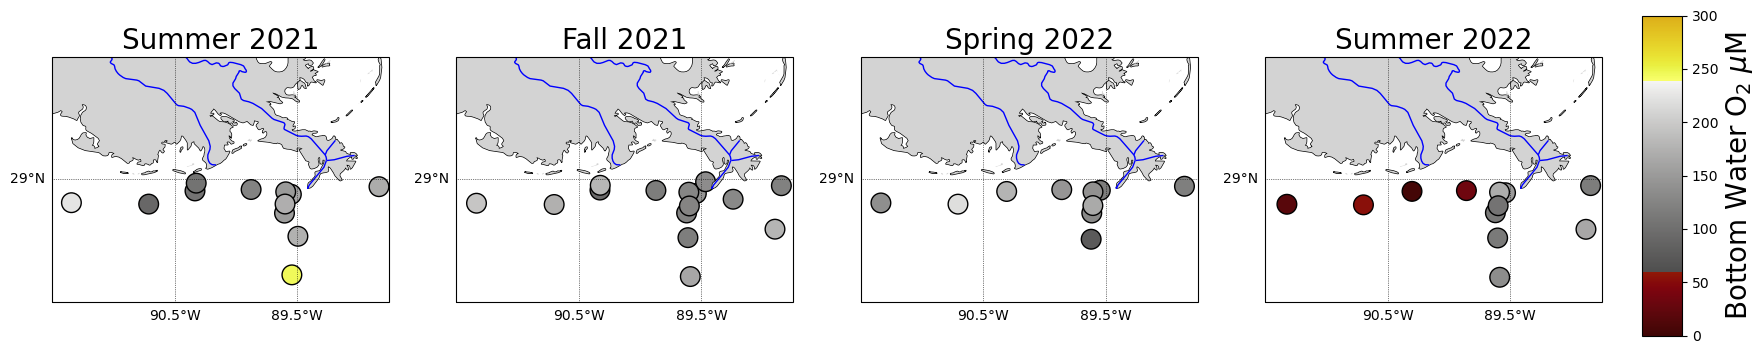

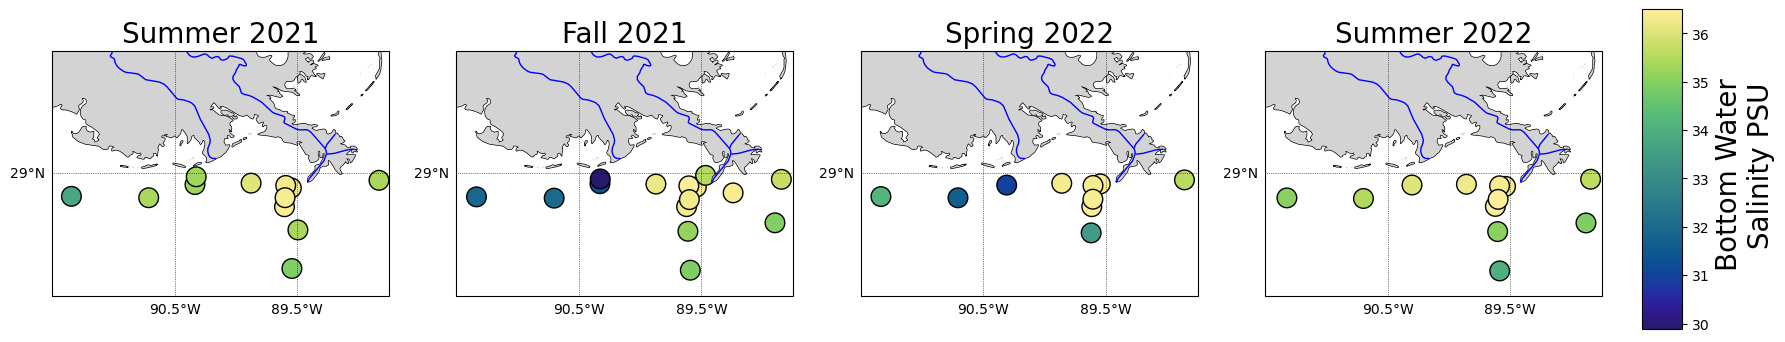

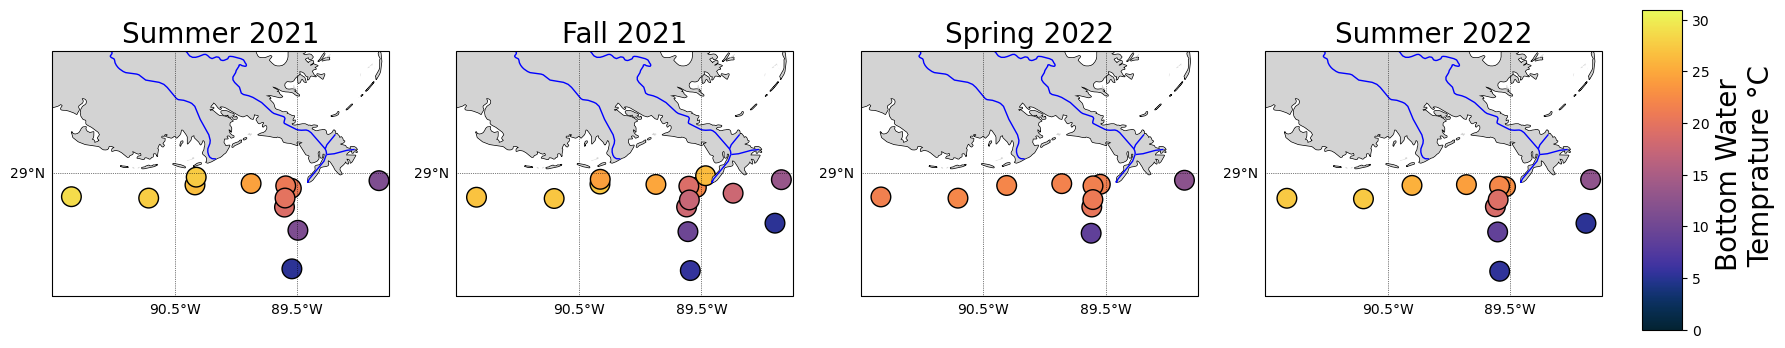

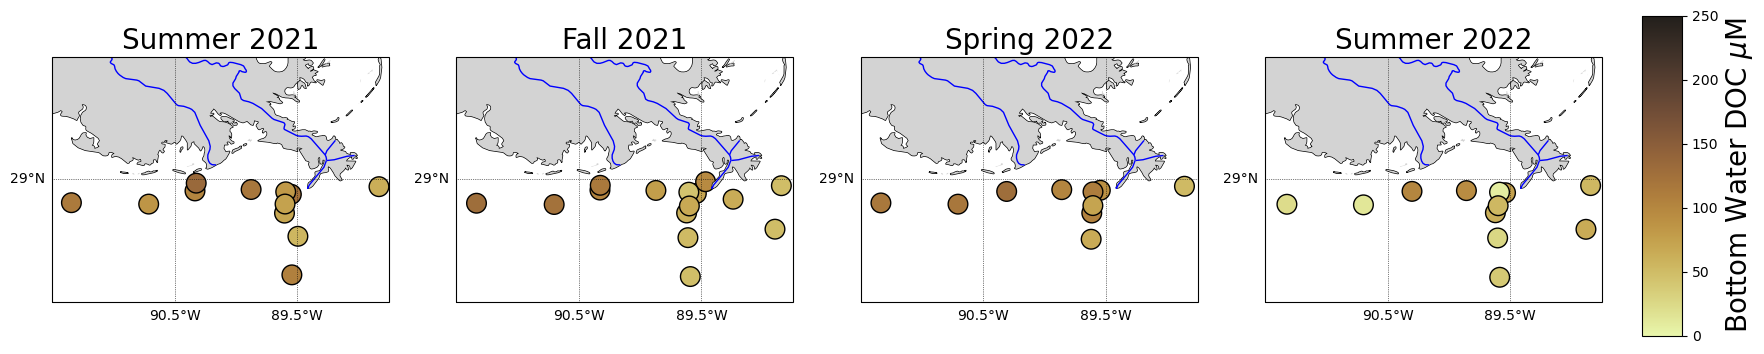

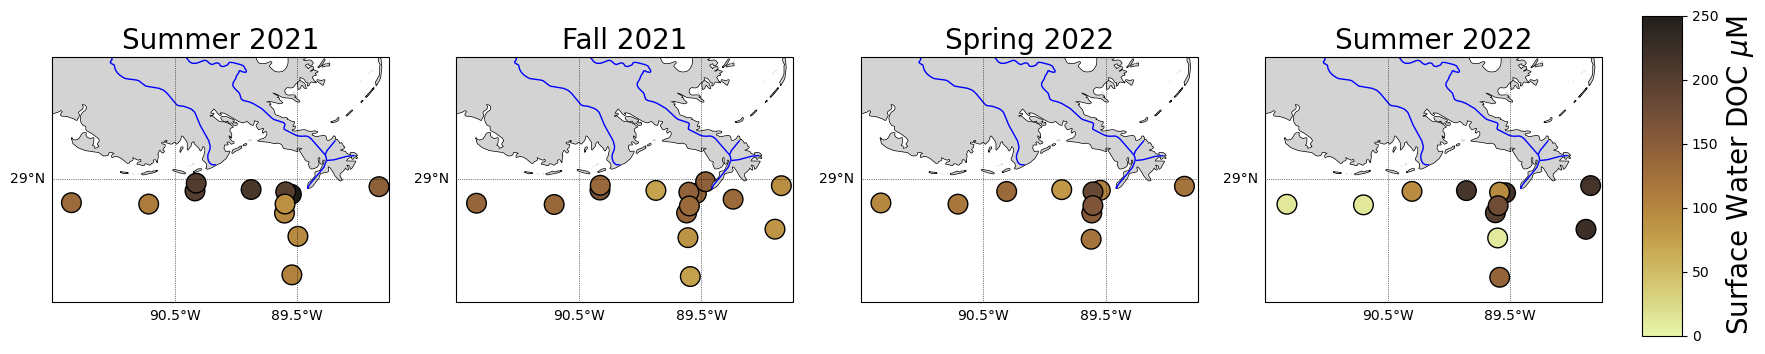

In [13]:
data_f = df_o2
topic = 'O2_uM_bottom'
cb_name = r'Bottom Water O$_2$ $\mu$M'
map_O2(data_f, topic, cb_name)


data_f = df_o2
topic = 'sal_bottom'
cb_name = 'Bottom Water \n Salinity PSU'
map_sal(data_f, topic, cb_name)


data_f = df_o2
topic = 'temp_bottom'
cb_name = 'Bottom Water \n Temprature °C'
map_temp(data_f, topic, cb_name)

data_f = df
topic = 'NPOC_uM'
cb_name = r'Bottom Water DOC $\mu$M'
map_doc(data_f, topic, cb_name)

    
data_f = df
topic = 'NPOC_uM_surf'
cb_name = r'Surface Water DOC $\mu$M'
map_doc(data_f, topic, cb_name)

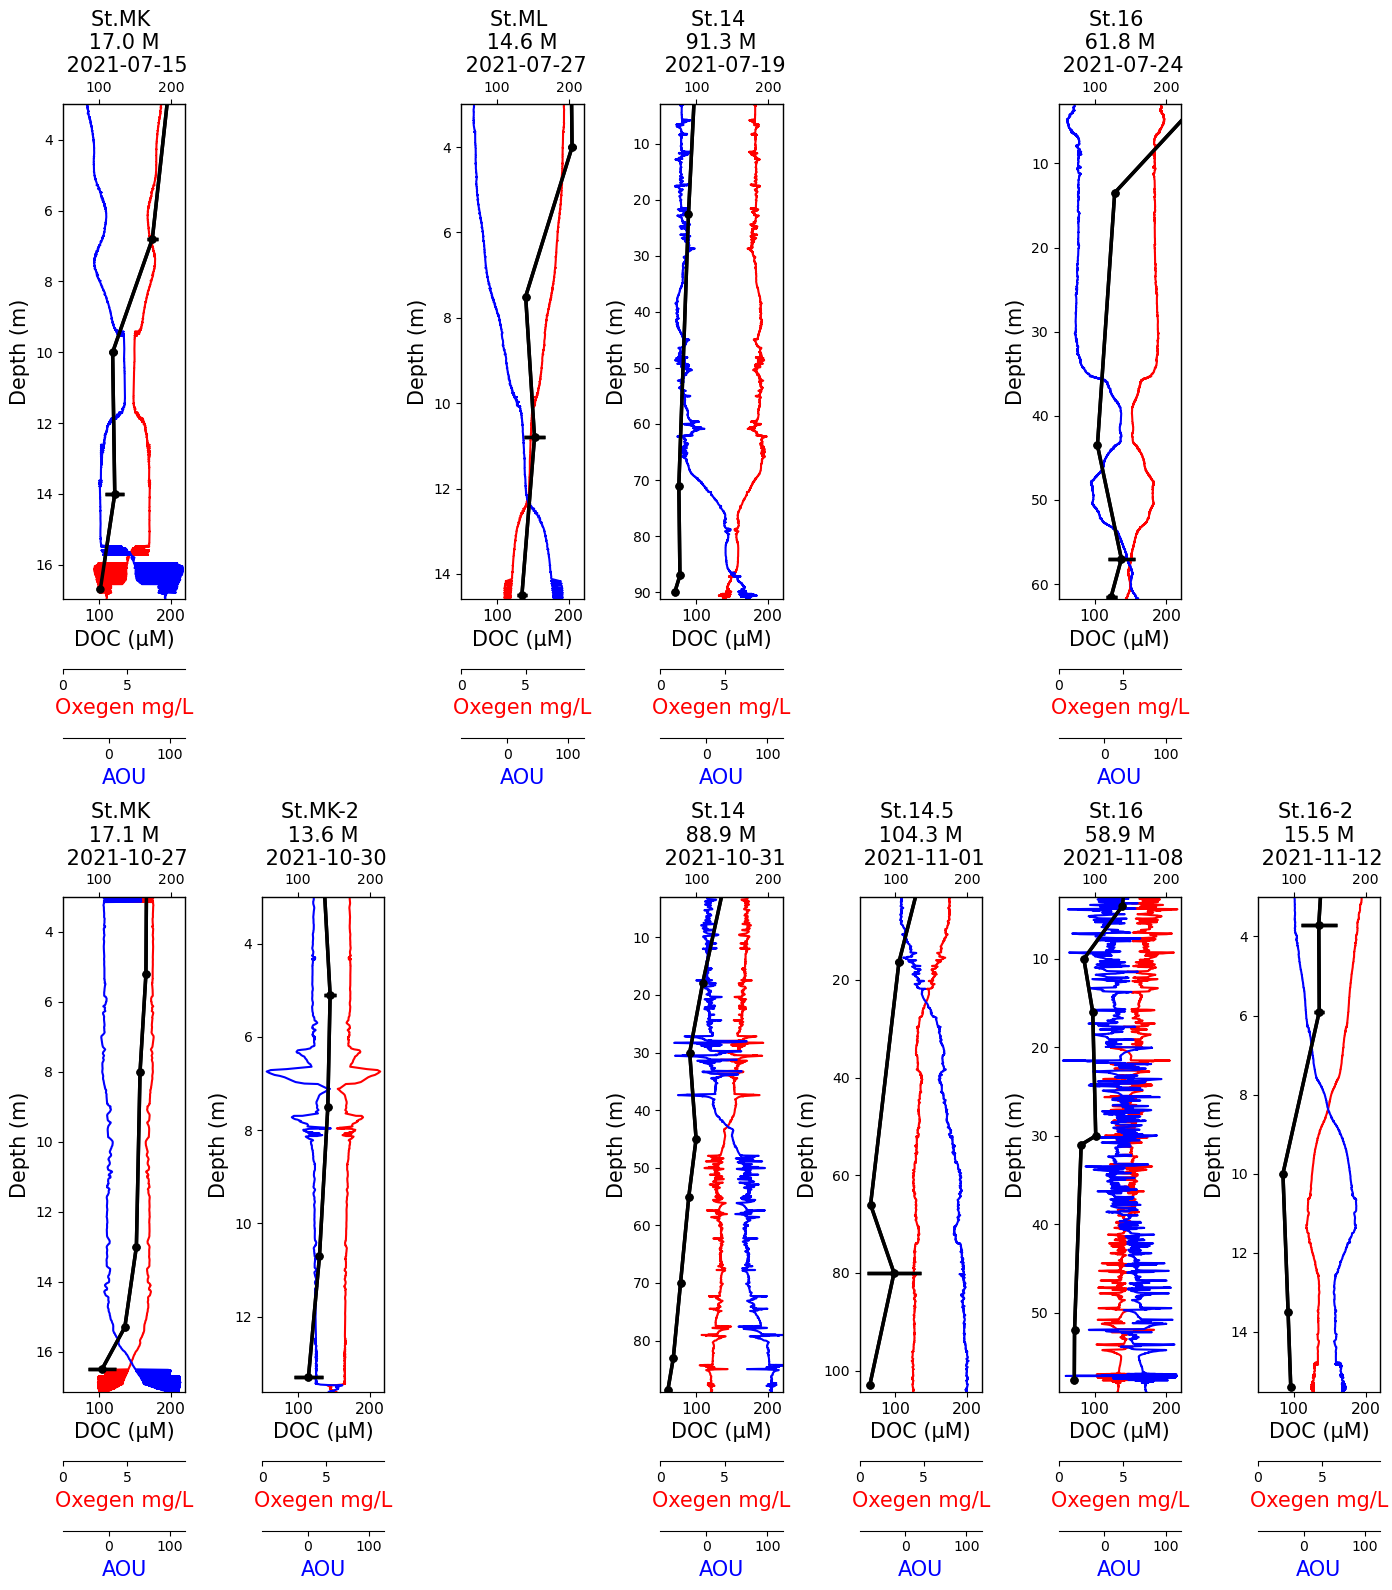

In [14]:
stations = ['St.MK', 'St.MK-2', 'St.ML','St.14', 'St.14.5', 'St.16', 'St.16-2']
trips = ['GOM2021','GOM21FA']

# Setup colormap and CDOM Spectra
fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*8))

# Determine the maximum depth for consistent plotting

txt_s = 15

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        ax = axes[i, j]
        subset_df = df_doc_wc[(df_doc_wc['Campaign'] == trip) & (df_doc_wc['Location'] == station)]
        subset_df = subset_df.sort_values(by=['Depth'])
        subset_df_avg = subset_df.groupby('Depth')['NPOC_uM'].mean().reset_index()
        subset_df_sem = subset_df.groupby('Depth')['NPOC_uM'].sem().reset_index()
        subset_df_err = subset_df.groupby('Depth')['NPOC_uM_std'].mean().reset_index()

        
        subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
        subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])

        if not subset_df.empty:
            # Variables
            doc_uM = np.asarray(subset_df_avg['NPOC_uM'], dtype=float).ravel()
            doc_err_1 = np.asarray(subset_df_err['NPOC_uM_std'], dtype=float).ravel()
            doc_err_2 = np.asarray(subset_df_sem['NPOC_uM'], dtype=float).ravel()
            doc_err_2 = np.nan_to_num(doc_err_2, nan=0)
            doc_err = doc_err_2 + doc_err_1
            doc_depth = np.asarray(subset_df_avg['Depth'], dtype=float).ravel()
            
            date_txt = pd.to_datetime(subset_df['Date']).iloc[0].strftime('%Y-%m-%d')
            
            o2 = np.asarray(subset_ds['sbeox0Mg/L'], dtype=float).ravel()
            aou = np.asarray(subset_ds['aou'], dtype=float).ravel()
            o2_depth = np.asarray(subset_ds['Pressure [dbar]'], dtype=float).ravel()
            
            max_depth = subset_ds['Pressure [dbar]'].max()
            
            # PLOT DOC
            ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black', markersize = 5)
            ax.errorbar(doc_uM, doc_depth, xerr=doc_err, color="black", linewidth = 2.5)
            ax.set_xlim(50, 220)
            ax.set_ylim(max_depth, 3)
            ax.set_ylabel('Depth (m)', size=txt_s, c='black')
            ax.set_xlabel('DOC (μM)', size=txt_s)
            
            # Plot O2
            ax2 = ax.twiny()
            ax2.plot(o2, o2_depth, ls='-', c='r')
            ax2.set_xlim(0, 9.5)
            
            ax2.set_xlabel('Oxegen mg/L', size=txt_s, color = 'r')
            ax2.xaxis.set_ticks_position('bottom')
            ax2.xaxis.set_label_position('bottom')
            ax2.spines['bottom'].set_position(('outward', 50))
                
                
            # Plot AOU
            ax3 = ax.twiny()
            ax3.plot(aou, o2_depth, ls='-', c='b')
            ax3.set_xlim(-75, 125)
            
            ax3.set_xlabel('AOU', size=txt_s, color = 'b')
            ax3.xaxis.set_ticks_position('bottom')
            ax3.xaxis.set_label_position('bottom')
            ax3.spines['bottom'].set_position(('outward', 100))
            
            ax4 = ax.twiny()
            ax4.plot(doc_uM, doc_depth, 'o', ls='-', c='black', markersize = 5)
            ax4.errorbar(doc_uM, doc_depth, xerr=doc_err, color="black", linewidth = 2.5)
            ax4.set_xlim(50, 220)
            ax4.set_ylim(max_depth, 3)
            
            
            # Meta info for title
            water_depth = round(max_depth, 1)
            ax.set_title(f'{station} \n {water_depth} M \n {date_txt}', size=15)
        else:
            ax.axis('off')

        #ax.set_xlabel('DOC (μM)', size=txt_s, c='black')
        ax.xaxis.set_tick_params(labelsize=txt_s*.75)

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

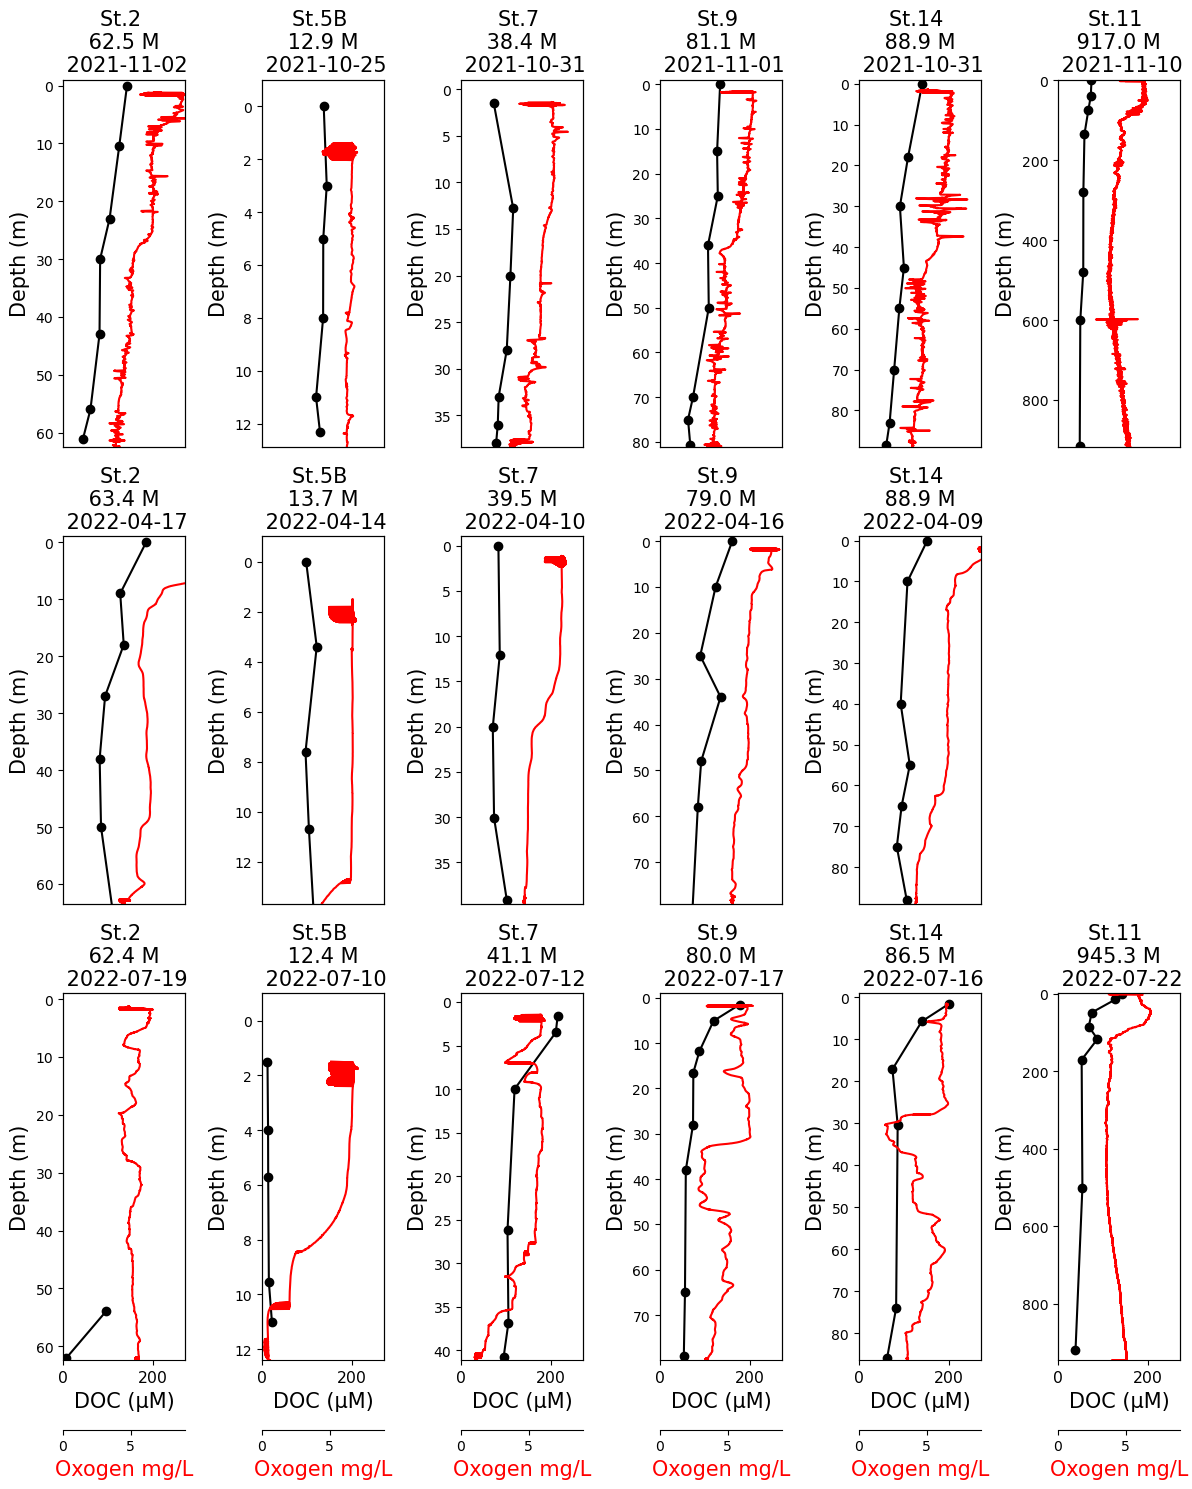

In [15]:
stations = ['St.2', 'St.5B','St.7','St.9','St.14','St.11']
trips = ['GOM21FA', 'GOM22SP', 'GOM22SU']

# Setup colormap and CDOM Spectra
fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

# Determine the maximum depth for consistent plotting

txt_s = 15

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        ax = axes[i, j]
        subset_df = df_doc_wc[(df_doc_wc['Campaign'] == trip) & (df_doc_wc['Location'] == station)]
        subset_df = subset_df.sort_values(by=['Depth'])
        subset_df_avg = subset_df.groupby('Depth')['NPOC_uM'].mean().reset_index()

        
        subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
        subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])

        if not subset_df.empty:
            # Variables
            doc_uM = np.asarray(subset_df_avg['NPOC_uM'], dtype=float).ravel()
            doc_depth = np.asarray(subset_df_avg['Depth'], dtype=float).ravel()
            
            date_txt = pd.to_datetime(subset_df['Date']).iloc[0].strftime('%Y-%m-%d')
            
            o2 = np.asarray(subset_ds['sbeox0Mg/L'], dtype=float).ravel()
            o2_depth = np.asarray(subset_ds['Pressure [dbar]'], dtype=float).ravel()
            
            max_depth = subset_ds['Pressure [dbar]'].max()
            
            # PLOT DOC
            ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black')
            ax.set_xlim(0, df_doc_wc['NPOC_uM'].max())
            ax.set_ylim(max_depth, -1)
            ax.set_ylabel('Depth (m)', size=txt_s, c='black')
            if i == 2:
                ax.set_xlabel('DOC (μM)', size=txt_s)
            if i != 2:
                ax.set_xlabel('')
                ax.xaxis.set_ticklabels([])
                ax.set_xticks([])
            
            # Plot O2
            ax2 = ax.twiny()
            ax2.plot(o2, o2_depth, ls='-', c='r')
            ax2.set_xlim(0, 9)
            if i == 2:
                ax2.set_xlabel('Oxogen mg/L', size=txt_s, color = 'r')
                ax2.xaxis.set_ticks_position('bottom')
                ax2.xaxis.set_label_position('bottom')
                ax2.spines['bottom'].set_position(('outward', 50))
                
            # Turn off other axis
            if i != 2:
                ax2.set_xlabel('')
                ax2.xaxis.set_ticklabels([])
                ax2.set_xticks([])
                

            # Meta info for title
            water_depth = round(max_depth, 1)
            ax.set_title(f'{station} \n {water_depth} M \n {date_txt}', size=15)
        else:
            ax.axis('off')

        #ax.set_xlabel('DOC (μM)', size=txt_s, c='black')
        ax.xaxis.set_tick_params(labelsize=txt_s*.75)

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

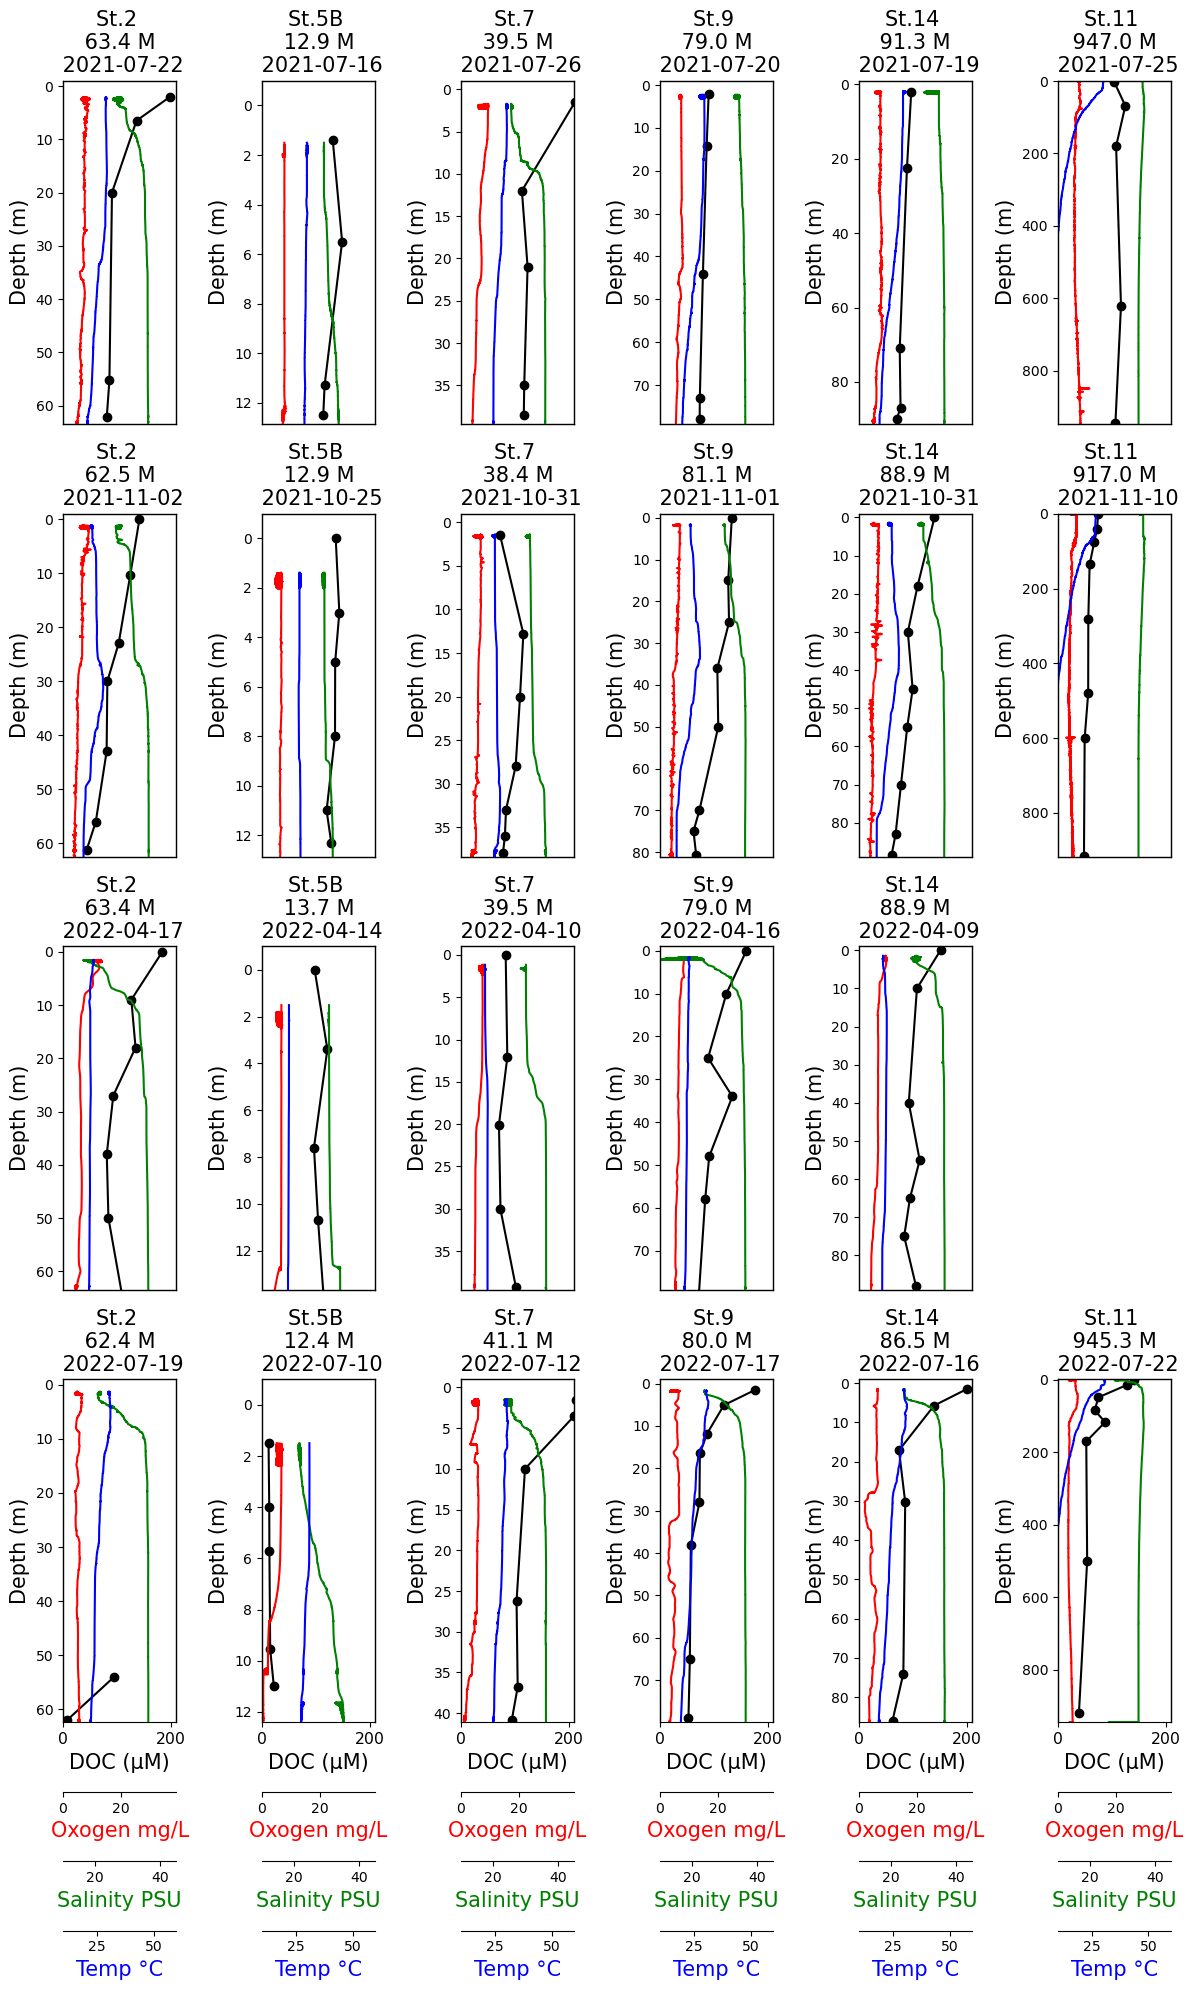

In [16]:
stations = ['St.2', 'St.5B','St.7','St.9','St.14','St.11']
trips = ['GOM2021','GOM21FA', 'GOM22SP', 'GOM22SU']

# Setup colormap and CDOM Spectra
fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

# Determine the maximum depth for consistent plotting

txt_s = 15

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        ax = axes[i, j]
        subset_df = df_doc_wc[(df_doc_wc['Campaign'] == trip) & (df_doc_wc['Location'] == station)]
        subset_df = subset_df.sort_values(by=['Depth'])
        subset_df_avg = subset_df.groupby('Depth')['NPOC_uM'].mean().reset_index()

        
        subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
        subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])

        if not subset_df.empty:
            # Variables
            doc_uM = np.asarray(subset_df_avg['NPOC_uM'], dtype=float).ravel()
            doc_depth = np.asarray(subset_df_avg['Depth'], dtype=float).ravel()
            
            date_txt = pd.to_datetime(subset_df['Date']).iloc[0].strftime('%Y-%m-%d')
            
            o2 = np.asarray(subset_ds['sbeox0Mg/L'], dtype=float).ravel()
            o2_depth = np.asarray(subset_ds['Pressure [dbar]'], dtype=float).ravel()
            
            sal = np.asarray(subset_ds['sal00'], dtype=float).ravel()
            temp = np.asarray(subset_ds['t068C'], dtype=float).ravel()            
            
            max_depth = subset_ds['Pressure [dbar]'].max()
            
            # PLOT DOC
            ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black')
            ax.set_xlim(0, 210)
            ax.set_ylim(max_depth, -1)
            ax.set_ylabel('Depth (m)', size=txt_s, c='black')
            
            # Plot O2
            ax2 = ax.twiny()
            ax2.plot(o2, o2_depth, ls='-', c='r')
            ax2.set_xlim(0, 39)
            
            ax3 = ax.twiny()
            ax3.plot(sal, o2_depth, ls='-', c='g')
            ax3.set_xlim(10, 45)
            
            ax4 = ax.twiny()
            ax4.plot(temp, o2_depth, ls='-', c='b')
            ax4.set_xlim(10, 60)
            if i == 3:
                ax.set_xlabel('DOC (μM)', size=txt_s, color = 'black')
                ax.xaxis.set_ticks_position('bottom')
                ax.xaxis.set_label_position('bottom')
                
                ax2.set_xlabel('Oxogen mg/L', size=txt_s, color = 'r')
                ax2.xaxis.set_ticks_position('bottom')
                ax2.xaxis.set_label_position('bottom')
                ax2.spines['bottom'].set_position(('outward', 50))
                
                ax3.set_xlabel('Salinity PSU', size=txt_s, color = 'g')
                ax3.xaxis.set_ticks_position('bottom')
                ax3.xaxis.set_label_position('bottom')
                ax3.spines['bottom'].set_position(('outward', 100))
                
                ax4.set_xlabel('Temp °C', size=txt_s, color = 'b')
                ax4.xaxis.set_ticks_position('bottom')
                ax4.xaxis.set_label_position('bottom')
                ax4.spines['bottom'].set_position(('outward', 150))
                
            # Turn off other axis
            if i != 3:
                ax2.set_xlabel('')
                ax2.xaxis.set_ticklabels([])
                ax2.set_xticks([])
                ax.set_xlabel('')
                ax.xaxis.set_ticklabels([])
                ax.set_xticks([])
                ax3.set_xlabel('')
                ax3.xaxis.set_ticklabels([])
                ax3.set_xticks([])
                ax4.set_xlabel('')
                ax4.xaxis.set_ticklabels([])
                ax4.set_xticks([])
                

            # Meta info for title
            water_depth = round(max_depth, 1)
            ax.set_title(f'{station} \n {water_depth} M \n {date_txt}', size=15)
        else:
            ax.axis('off')

        ax.xaxis.set_tick_params(labelsize=txt_s*.75)

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

# Initialize lists to store the data
data_to_save = []

stations = df_doc_wc['Location'].unique()
trips = df_doc_wc['Campaign'].unique()

# Loop through trips and stations
for trip in trips:
    for station in stations:
        subset_df = df_doc_wc[(df_doc_wc['Campaign'] == trip) & (df_doc_wc['Location'] == station)]
        subset_df = subset_df.sort_values(by=['Depth'])
        subset_df_avg = subset_df.groupby('Depth')['NPOC_uM'].mean().reset_index()
        subset_df_avg_sorted = subset_df_avg.sort_values(by='Depth', ascending=False)
        highest_two_depths_df = subset_df_avg_sorted.head(2)

        # Save highest_two_depths_df to the list
        highest_two_depths_list.append(highest_two_depths_df)

        subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
        subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])

        # Check if 'Depth' column exists in subset_ds
        if 'Depth' in highest_two_depths_df.columns:
            # Get the two depth values from highest_two_depths_df
            depth_values = highest_two_depths_df['Depth'].values
            closest_pressure_values = []
            for depth in depth_values:
                closest_pressure_values.append(subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - depth).idxmin(), 'Pressure [dbar]'])

            filtered_subset_ds = subset_ds[subset_ds['Pressure [dbar]'].isin(closest_pressure_values)]

            if len(filtered_subset_ds) >= 2:
                # Calculate the difference in NPOC_uM between the two highest depths
                npoc_diff = highest_two_depths_df.iloc[0]['NPOC_uM'] - highest_two_depths_df.iloc[1]['NPOC_uM']

                # Calculate the difference in 'sbeox0Mg/L' between the two closest pressure values
                sbeox_diff = filtered_subset_ds.iloc[0]['sbeox0Mg/L'] - filtered_subset_ds.iloc[1]['sbeox0Mg/L']

                # Store the data to save
                data_to_save.append({
                    'Campaign': trip,
                    'Location': station,
                    'NPOC_uM_Diff': npoc_diff,
                    'sbeox0Mg/L_Diff': sbeox_diff
                })
            else:
                print(f"Not enough data points for trip {trip} and station {station}")

# Create a DataFrame from the data to save
data_to_save_df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
data_to_save_df


In [17]:
import pandas as pd
import numpy as np

# Initialize an empty list to store the filtered data and highest_two_depths_df
data_to_save = []


stations = df_doc_wc['Location'].unique()
trips = df_doc_wc['Campaign'].unique()

# Loop through trips and stations
for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        subset_df = df_doc_wc[(df_doc_wc['Campaign'] == trip) & (df_doc_wc['Location'] == station)]
        if len(subset_df) >= 2: 
            subset_df = subset_df.sort_values(by=['Depth'])
            subset_df_avg = subset_df.groupby('Depth')['NPOC_uM'].mean().reset_index()
            subset_df_avg_sorted = subset_df_avg.sort_values(by='Depth', ascending=False)
            highest_two_depths_df = subset_df_avg_sorted.head(2)
        
            NPOC_values = highest_two_depths_df['NPOC_uM'].values
            depth_values = highest_two_depths_df['Depth'].values
            
            NPOC_1 = NPOC_values[0]
            NPOC_2 = NPOC_values[1]
        
            NPOC_dep_1 = depth_values[0]
            NPOC_dep_2 = depth_values[1]
        
            npoc_diff = NPOC_1 - NPOC_2

            subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
            subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])
        
            closest_pressure_values_1 = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - depth_values[0]).idxmin(), 'Pressure [dbar]']
            closest_pressure_values_2 = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - depth_values[1]).idxmin(), 'Pressure [dbar]']

            closest_pressure_values_1 = closest_pressure_values_1.mean()
            closest_pressure_values_2 = closest_pressure_values_2.mean()
        
            closest_ox_values_1 = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - depth_values[0]).idxmin(), 'ox_uM']
            closest_ox_values_2 = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - depth_values[1]).idxmin(), 'ox_uM']

            closest_ox_values_1 = closest_ox_values_1.mean()
            closest_ox_values_2 = closest_ox_values_2.mean()
        
            sbeox_diff = closest_ox_values_1.mean() - closest_ox_values_2.mean()
        
            data_to_save.append({'Campaign': trip,
                                 'Location': station,
                                 'NPOC_uM_Diff': npoc_diff,
                                 'ox_uM_Diff': sbeox_diff,
                                 'NPOC_uM_upper': NPOC_2,
                                 'NPOC_uM_lower': NPOC_1,
                                 'Depth_doc_upper': NPOC_dep_2,
                                 'Depth_doc_lower': NPOC_dep_1, 
                                 'ox_uM_upper': closest_ox_values_2, 
                                 'ox_uM_lower': closest_ox_values_1, 
                                 'Depth_ctd_upper': closest_pressure_values_2,
                                 'Depth_ctd_lower': closest_pressure_values_1
                                })
        else: 
            print(f'fail to run {trip} {station}')
# Create a DataFrame from the data to save
data_to_save_df = pd.DataFrame(data_to_save)
        
data_to_save_df

fail to run GOM2021 St.6
fail to run GOM2021 St.MK-2
fail to run GOM2021 St.14.5
fail to run GOM2021 St.12
fail to run GOM2021 St.16-2
fail to run GOM21FA St.ML
fail to run GOM22SP St.11
fail to run GOM22SP St.ML
fail to run GOM22SP St.6
fail to run GOM22SP St.MK-2
fail to run GOM22SP St.14.5
fail to run GOM22SP St.12
fail to run GOM22SP St.16-2
fail to run GOM22SU St.ML
fail to run GOM22SU St.6
fail to run GOM22SU St.MK-2
fail to run GOM22SU St.14.5
fail to run GOM22SU St.16-2


Campaign Location  NPOC_uM_Diff  ox_uM_Diff  NPOC_uM_upper  NPOC_uM_lower  \
0   GOM2021    St.MK    -20.062500   -110.3552     121.958333     101.895833   
1   GOM2021    St.5B     -2.437500    -17.5648     116.104167     113.666667   
2   GOM2021     St.4     -5.239583    -61.0432      91.000000      85.760417   
3   GOM2021    St.14     -6.929167     -8.7040      77.160417      70.231250   
4   GOM2021     St.9     -0.237500     -7.6192      73.912500      73.675000   
5   GOM2021    St.13     -2.135417      0.5568      57.687500      55.552083   
6   GOM2021     St.2     -4.981250    -45.0976      86.083333      81.102083   
7   GOM2021    St.15      0.297917     -0.6400      62.777083      63.075000   
8   GOM2021    St.16    -14.291667    -10.1632     137.270833     122.979167   
9   GOM2021    St.11    -10.333333     54.0608     116.958333     106.625000   
10  GOM2021     St.7     -0.770833    -11.0816     117.291667     116.520833   
11  GOM2021    St.ML    -17.541667    -65.3440     151.854167     134.312500   
12  GOM21FA    St.MK    -31.708333    -39.4944     135.979167     104.270833   
13  GOM21FA    St.5B      8.604167      0.7296     119.791667     128.395833   
14  GOM21FA     St.4     22.012500    -26.8224     101.466667     123.479167   
15  GOM21FA    St.14     -7.462500     -3.6064      67.983333      60.520833   
16  GOM21FA     St.9      4.890278    -24.8512      62.212500      67.102778   
17  GOM21FA    St.13     -4.469819     -5.8976      56.861259      52.391440   
18  GOM21FA     St.2    -16.910417     -3.7632      60.760417      43.850000   
19  GOM21FA    St.15     -0.647917     -1.6768      49.887500      49.239583   
20  GOM21FA    St.16     -0.339583    -24.6720      72.091667      71.752083   
21  GOM21FA    St.11     -1.239583     35.9264      49.579167      48.339583   
22  GOM21FA     St.7     -3.641667    -44.4768      81.479167      77.837500   
23  GOM21FA     St.6     -7.666667     -6.3936     129.833333     122.166667   
24  GOM21FA  St.MK-2    -15.375000     -3.4784     129.750000     114.375000   
25  GOM21FA  St.14.5    -33.711111     -2.3584      97.961111      64.250000   
26  GOM21FA    St.12      1.004167      3.3312      47.870833      48.875000   
27  GOM21FA  St.16-2      3.706942    -13.5840      92.168534      95.875476   
28  GOM22SP    St.MK     41.520833    -26.2304      86.791667     128.312500   
29  GOM22SP    St.5B     11.683333    -70.4064     103.983333     115.666667   
30  GOM22SP     St.4     -7.541667    -10.4128     124.000000     116.458333   
31  GOM22SP    St.14     21.887500    -20.3264      83.904167     105.791667   
32  GOM22SP     St.9    -11.725000    -13.5968      83.879167      72.154167   
33  GOM22SP    St.13      9.575000    -29.4048      55.033333      64.608333   
34  GOM22SP     St.2     26.295833    -42.5600      84.204167     110.500000   
35  GOM22SP    St.15     -5.537500     -4.0064      58.050000      52.512500   
36  GOM22SP    St.16      8.562500    -24.9216      81.958333      90.520833   
37  GOM22SP     St.7     28.356250     -8.3136      73.279167     101.635417   
38  GOM22SU    St.MK      5.888889   -136.6656      95.416667     101.305556   
39  GOM22SU    St.5B      6.792833    -53.5200      15.169299      21.962132   
40  GOM22SU     St.4     -1.899598     -2.5056      14.712090      12.812491   
41  GOM22SU    St.14    -20.143750    -34.2496      82.400000      62.256250   
42  GOM22SU     St.9     -2.562500    -40.3232      55.420833      52.858333   
43  GOM22SU    St.13      1.736309      0.9952      25.108172      26.844481   
44  GOM22SU     St.2    -87.519690      5.6224      95.103841       7.584151   
45  GOM22SU    St.15     -9.654167     -4.2144      62.904167      53.250000   
46  GOM22SU    St.16    -29.906250      2.2176     104.479167      74.572917   
47  GOM22SU    St.11    -15.291667     44.6816      54.237500      38.945833   
48  GOM22SU     St.7    -10.833333    -39.9008     105.187500      94.354167   
49 

In [18]:
data_to_save_df['Depth_doc_diff'] = data_to_save_df['Depth_doc_lower'] - data_to_save_df['Depth_doc_upper']
data_to_save_df['Depth_ctd_diff'] = data_to_save_df['Depth_ctd_lower'] - data_to_save_df['Depth_ctd_upper']

data_to_save_df['O2_change_per_meter'] = data_to_save_df['ox_uM_Diff'] / data_to_save_df['Depth_ctd_diff']
data_to_save_df['DOC_change_per_meter'] = data_to_save_df['NPOC_uM_Diff'] / data_to_save_df['Depth_doc_diff']
data_to_save_df['Depth_ctd_lower_log'] = np.log(data_to_save_df['Depth_ctd_lower'] )


data_bottom_water = data_to_save_df
data_bottom_water['code'] = data_bottom_water['Location'] + '_' + data_bottom_water['Campaign']

data_bottom_water

Campaign Location  NPOC_uM_Diff  ox_uM_Diff  NPOC_uM_upper  NPOC_uM_lower  \
0   GOM2021    St.MK    -20.062500   -110.3552     121.958333     101.895833   
1   GOM2021    St.5B     -2.437500    -17.5648     116.104167     113.666667   
2   GOM2021     St.4     -5.239583    -61.0432      91.000000      85.760417   
3   GOM2021    St.14     -6.929167     -8.7040      77.160417      70.231250   
4   GOM2021     St.9     -0.237500     -7.6192      73.912500      73.675000   
5   GOM2021    St.13     -2.135417      0.5568      57.687500      55.552083   
6   GOM2021     St.2     -4.981250    -45.0976      86.083333      81.102083   
7   GOM2021    St.15      0.297917     -0.6400      62.777083      63.075000   
8   GOM2021    St.16    -14.291667    -10.1632     137.270833     122.979167   
9   GOM2021    St.11    -10.333333     54.0608     116.958333     106.625000   
10  GOM2021     St.7     -0.770833    -11.0816     117.291667     116.520833   
11  GOM2021    St.ML    -17.541667    -65.3440     151.854167     134.312500   
12  GOM21FA    St.MK    -31.708333    -39.4944     135.979167     104.270833   
13  GOM21FA    St.5B      8.604167      0.7296     119.791667     128.395833   
14  GOM21FA     St.4     22.012500    -26.8224     101.466667     123.479167   
15  GOM21FA    St.14     -7.462500     -3.6064      67.983333      60.520833   
16  GOM21FA     St.9      4.890278    -24.8512      62.212500      67.102778   
17  GOM21FA    St.13     -4.469819     -5.8976      56.861259      52.391440   
18  GOM21FA     St.2    -16.910417     -3.7632      60.760417      43.850000   
19  GOM21FA    St.15     -0.647917     -1.6768      49.887500      49.239583   
20  GOM21FA    St.16     -0.339583    -24.6720      72.091667      71.752083   
21  GOM21FA    St.11     -1.239583     35.9264      49.579167      48.339583   
22  GOM21FA     St.7     -3.641667    -44.4768      81.479167      77.837500   
23  GOM21FA     St.6     -7.666667     -6.3936     129.833333     122.166667   
24  GOM21FA  St.MK-2    -15.375000     -3.4784     129.750000     114.375000   
25  GOM21FA  St.14.5    -33.711111     -2.3584      97.961111      64.250000   
26  GOM21FA    St.12      1.004167      3.3312      47.870833      48.875000   
27  GOM21FA  St.16-2      3.706942    -13.5840      92.168534      95.875476   
28  GOM22SP    St.MK     41.520833    -26.2304      86.791667     128.312500   
29  GOM22SP    St.5B     11.683333    -70.4064     103.983333     115.666667   
30  GOM22SP     St.4     -7.541667    -10.4128     124.000000     116.458333   
31  GOM22SP    St.14     21.887500    -20.3264      83.904167     105.791667   
32  GOM22SP     St.9    -11.725000    -13.5968      83.879167      72.154167   
33  GOM22SP    St.13      9.575000    -29.4048      55.033333      64.608333   
34  GOM22SP     St.2     26.295833    -42.5600      84.204167     110.500000   
35  GOM22SP    St.15     -5.537500     -4.0064      58.050000      52.512500   
36  GOM22SP    St.16      8.562500    -24.9216      81.958333      90.520833   
37  GOM22SP     St.7     28.356250     -8.3136      73.279167     101.635417   
38  GOM22SU    St.MK      5.888889   -136.6656      95.416667     101.305556   
39  GOM22SU    St.5B      6.792833    -53.5200      15.169299      21.962132   
40  GOM22SU     St.4     -1.899598     -2.5056      14.712090      12.812491   
41  GOM22SU    St.14    -20.143750    -34.2496      82.400000      62.256250   
42  GOM22SU     St.9     -2.562500    -40.3232      55.420833      52.858333   
43  GOM22SU    St.13      1.736309      0.9952      25.108172      26.844481   
44  GOM22SU     St.2    -87.519690      5.6224      95.103841       7.584151   
45  GOM22SU    St.15     -9.654167     -4.2144      62.904167      53.250000   
46  GOM22SU    St.16    -29.906250      2.2176     104.479167      74.572917   
47  GOM22SU    St.11    -15.291667     44.6816      54.237500      38.945833   
48  GOM22SU     St.7    -10.833333    -39.9008     105.187500      94.354167   
49 

In [19]:
import pandas as pd
import numpy as np

# Initialize an empty list to store the filtered data and highest_two_depths_df
data_save = []


stations = df_doc_wc['Location'].unique()
trips = df_doc_wc['Campaign'].unique()

# Loop through trips and stations
for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        subset_df = df_doc_wc[(df_doc_wc['Campaign'] == trip) & (df_doc_wc['Location'] == station)]
        if len(subset_df) >= 2: 
            subset_df = subset_df.sort_values(by=['Depth'])
            subset_df_avg = subset_df.groupby('Depth')['NPOC_uM'].mean().reset_index()
            subset_df_avg_sorted = subset_df_avg.sort_values(by='Depth', ascending=False)
            depths_df = subset_df_avg_sorted
        
            NPOC_values = depths_df['NPOC_uM'].values
            depth_values = depths_df['Depth'].values
            
            subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
            subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])
            

            subset_ds = ds[(ds['camp'] == trip) & (ds['station'] == station)]
            subset_ds = subset_ds.sort_values(by=['Pressure [dbar]'])
        
            val_save = []
            for val in depth_values: 
                closest_pressure_value = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - val).idxmin(), 'Pressure [dbar]']
                closest_ox_value = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - val).idxmin(), 'ox_uM']
                closest_temp_value = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - val).idxmin(), 't068C']
                closest_sal_value = subset_ds.loc[np.abs(subset_ds['Pressure [dbar]'] - val).idxmin(), 'sal00']
                
                val_save.append({'Press': closest_pressure_value.mean(),
                                 'ox': closest_ox_value.mean(),
                                 'temp': closest_temp_value.mean(),
                                 'sal': closest_sal_value.mean()})
                
            val_save_df = pd.DataFrame(val_save)
            val_save_df['NPOC_uM'] = NPOC_values
            val_save_df['Depth'] = depth_values
            val_save_df['Campaign'] = trip
            val_save_df['Location'] = station
            
            data_save.append(val_save_df)
        else: 
            print(f'fail to run {trip} {station}')
            
# Create a DataFrame from the data to save
data_save = pd.concat(data_save, ignore_index=True)
        
data_save

fail to run GOM2021 St.6
fail to run GOM2021 St.MK-2
fail to run GOM2021 St.14.5
fail to run GOM2021 St.12
fail to run GOM2021 St.16-2
fail to run GOM21FA St.ML
fail to run GOM22SP St.11
fail to run GOM22SP St.ML
fail to run GOM22SP St.6
fail to run GOM22SP St.MK-2
fail to run GOM22SP St.14.5
fail to run GOM22SP St.12
fail to run GOM22SP St.16-2
fail to run GOM22SU St.ML
fail to run GOM22SU St.6
fail to run GOM22SU St.MK-2
fail to run GOM22SU St.14.5
fail to run GOM22SU St.16-2


Press        ox     temp      sal     NPOC_uM  Depth Campaign Location
0    16.692  105.1808  26.7773  35.2552  101.895833   16.7  GOM2021    St.MK
1    13.995  215.5360  27.7091  34.4407  121.958333   14.0  GOM2021    St.MK
2    10.011  177.6544  27.5623  32.8513  119.000000   10.0  GOM2021    St.MK
3     6.815  216.8224  29.4177  25.8144  174.229167    6.8  GOM2021    St.MK
4     1.995  254.2464  30.0275  21.8121  200.041667    2.0  GOM2021    St.MK
..      ...       ...      ...      ...         ...    ...      ...      ...
305  70.620  197.5072  22.0523  36.3063   81.120833   70.6  GOM22SU    St.12
306  45.015  215.3152  23.4364  36.3388   87.166667   45.0  GOM22SU    St.12
307  21.002  193.1552  28.6777  35.7769   88.583333   21.0  GOM22SU    St.12
308   8.012  197.9904  30.6232  30.2381  147.541667    8.0  GOM22SU    St.12
309   1.800  171.6480  30.8455  22.9804  224.666667    1.8  GOM22SU    St.12

[310 rows x 8 columns]

In [20]:
data_wc = data_save



data_wc['Ts'] = (298.15 - data_wc['temp']) / (273.15 + data_wc['temp'])
data_wc['Ts'] = np.log(data_wc['Ts'] ) 


data_wc['density_kg_m3'] = seawater.dens(data_wc['sal'], data_wc['temp'], data_wc['Press'])  # density at specified pressure (in kg/m^3)
data_wc['density_kg_l'] = data_wc['density_kg_m3'] / 1000

data_wc['ox_umol_kg'] = data_wc['ox'] / data_wc['density_kg_l']

con1 = 5.80871
con2 = 3.20291
con3 = 4.17887 
con4 = 5.10006 
con5 = 9.86643e-2
con6 = 3.80369 

cof1 = -7.01577e-3
cof2 = -7.70028e-3
cof3 = -1.13864e-2
cof4 = -9.51519e-3
cof5 = -2.75915e-7

#as per book 
data_wc['ox_sat'] = con1+data_wc['Ts']*con2+(data_wc['Ts']**2)*con3+(data_wc['Ts']**3)*con4+(data_wc['Ts']**4)*con5+(data_wc['Ts']**5)*con6
data_wc['ox_sat'] = data_wc['ox_sat'] + data_wc['sal']*(cof1 + cof2*data_wc['Ts'] + cof3*data_wc['Ts']**2 + cof4*data_wc['Ts']**3 + cof5*data_wc['sal']**2)
data_wc['ox_sat'] = np.exp(data_wc['ox_sat'])

data_wc['aou'] = data_wc['ox_sat'] - data_wc['ox_umol_kg'] 

data_wc['group'] = "water_col"

# Define a function to assign group
def assign_group(df):
    max_depth_index = df['Depth'].idxmax()
    df.loc[df['Depth'] <= 5, 'group'] = 'Surface'
    df.loc[max_depth_index, 'group'] = 'BBL'
    return df

data_wc['aou-ceq'] = data_wc['aou'] * 0.72


# Apply the function within groups
data_wc = data_wc.groupby(['Campaign', 'Location']).apply(assign_group).reset_index(drop=True)
data_wc_all = data_wc

data_wc_bbl = data_wc[data_wc['group'] == "BBL"]
data_wc_surf = data_wc[data_wc['group'] == "Surface"]
data_wc = data_wc[data_wc['group'] == "water_col"]

data_wc_all

Press        ox     temp      sal     NPOC_uM    Depth Campaign  \
0    946.000  250.6848   5.1116  34.9340  106.625000  946.000  GOM2021   
1    621.025  196.6240   7.1954  34.9277  116.958333  621.000  GOM2021   
2    180.018  198.5504  15.8122  36.1124  107.937500  180.000  GOM2021   
3     68.202  239.5744  23.4754  36.6439  125.062500   68.200  GOM2021   
4      2.076  234.0288  29.9853  36.1905  104.270833    2.000  GOM2021   
..       ...       ...      ...      ...         ...      ...      ...   
305    5.280  164.0256  31.1527  27.6493  154.166667    5.290  GOM22SU   
306    3.597  160.2400  31.1229  24.0658  227.541667    3.600  GOM22SU   
307    2.483  172.5728  31.5218  20.4221  210.541667    2.480  GOM22SU   
308    1.769  107.4144  31.5681  20.1232  243.916667    1.498  GOM22SU   
309    1.769  107.4144  31.5681  20.1232   93.791667    1.000  GOM22SU   

    Location        Ts  density_kg_m3  density_kg_l  ox_umol_kg      ox_sat  \
0      St.11  0.051742    1031.946041      1.031946  242.924329  303.217297   
1      St.11  0.037145    1030.161924      1.030162  190.867082  288.978342   
2      St.11 -0.023192    1027.440899      1.027441  193.247514  239.007525   
3      St.11 -0.076883    1025.336385      1.025336  233.654441  207.174664   
4      St.11 -0.122578    1022.632919      1.022633  228.849273  186.986478   
..       ...       ...            ...           ...         ...         ...   
305    St.MK -0.130784    1015.860252      1.015860  161.464729  195.001414   
306    St.MK -0.130575    1013.194240      1.013194  158.153288  199.860328   
307    St.MK -0.133380    1010.346230      1.010346  170.805606  203.423534   
308    St.MK -0.133706    1010.105588      1.010106  106.339774  203.669695   
309    St.MK -0.133706    1010.105588      1.010106  106.339774  203.669695   

           aou      group    aou-ceq  
0    60.292967        BBL  43.410936  
1    98.111260  water_col  70.640107  
2    45.760010  water_col  32.947207  
3   -26.479777  water_col -19.065439  
4   -41.862795    Surface -30.141212  
..         ...        ...        ...  
305  33.536685  water_col  24.146413  
306  41.707040    Surface  30.029069  
307  32.617928    Surface  23.484908  
308  97.329921    Surface  70.077543  
309  97.329921    Surface  70.077543  

[310 rows x 16 columns]

In [21]:
def xyplotcolor(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].min()
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    

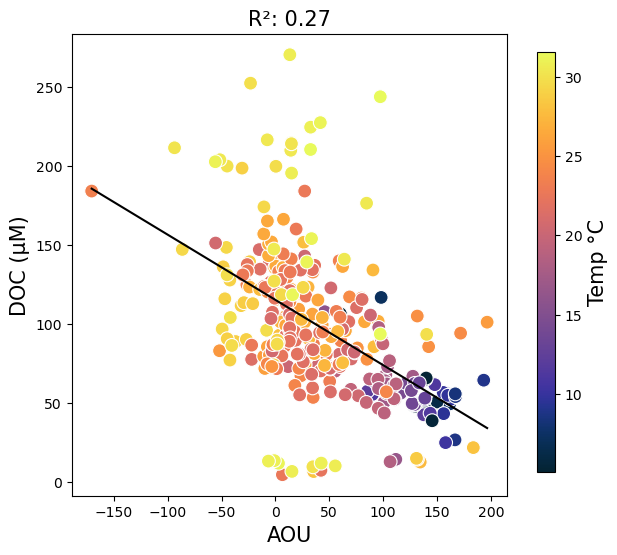

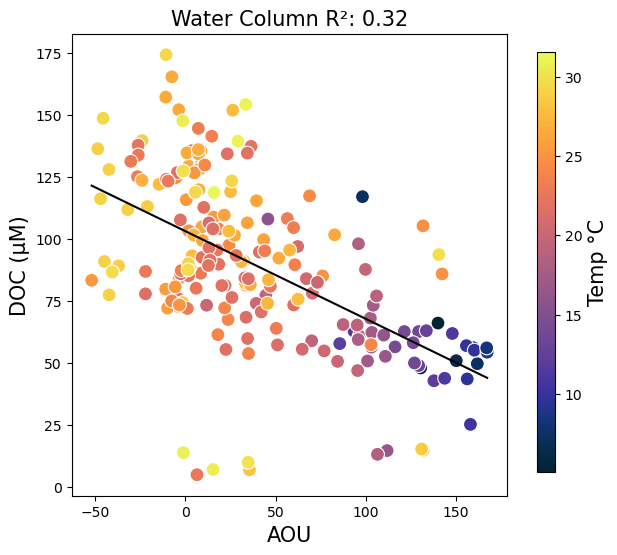

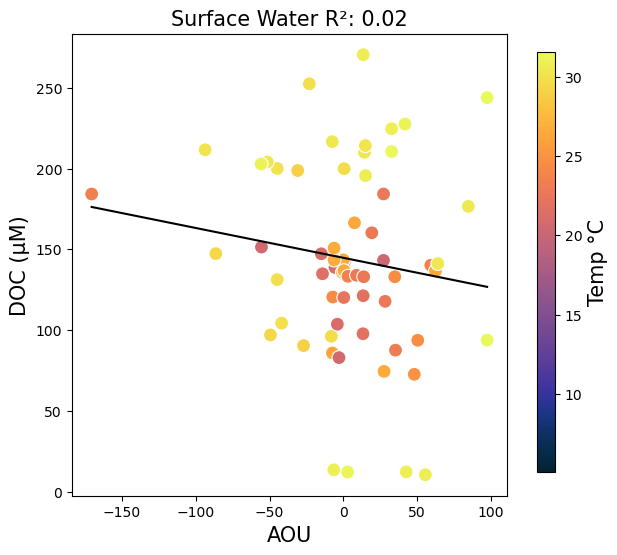

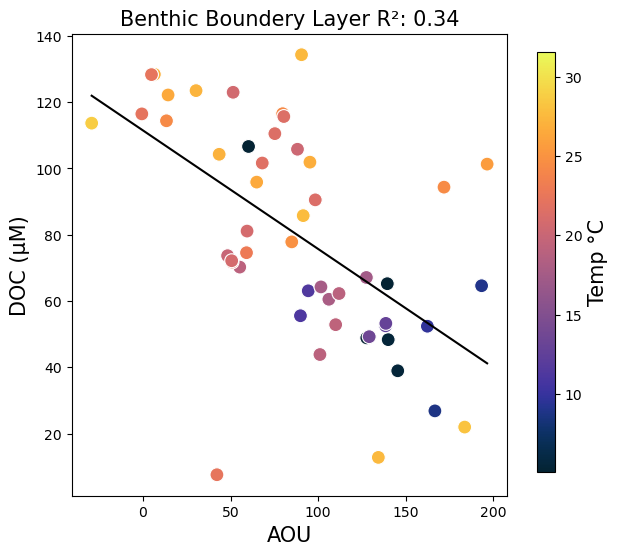

In [22]:

    
x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'temp'
z_var_lab = 'Temp °C'
z_var_color = cmo.thermal

titel = ""
save_name = 'aou_temp_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'aou_temp_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'aou_temp_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'aou_temp_bbl'
xyplotcolor(data_wc_bbl)

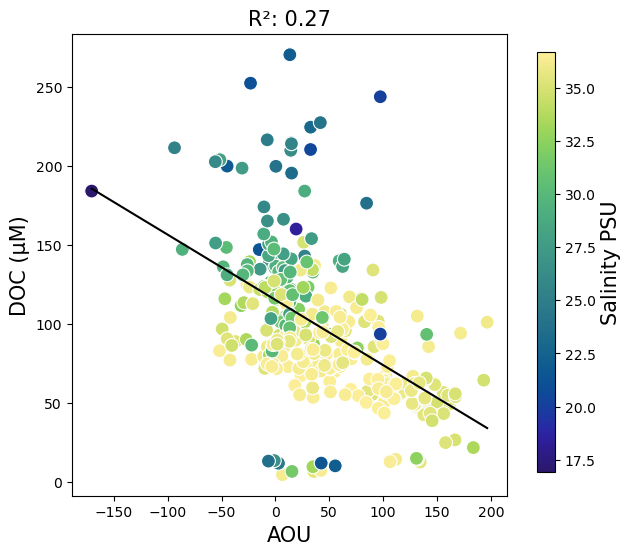

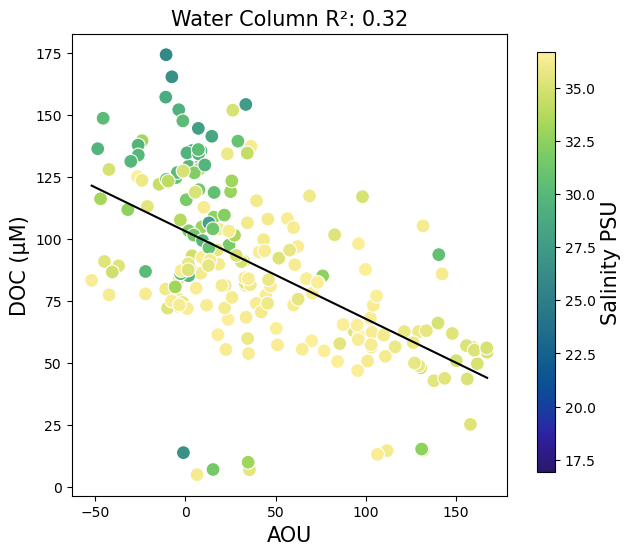

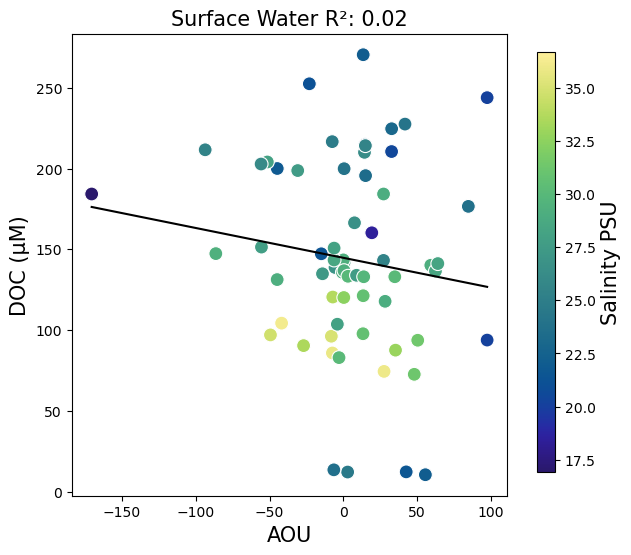

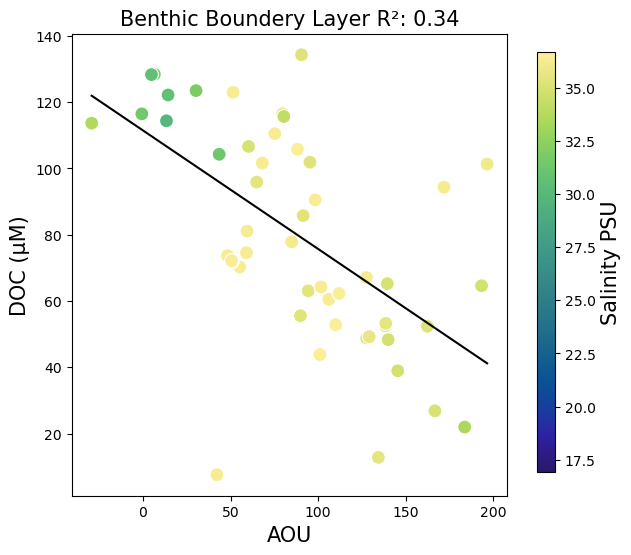

In [23]:

x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = ""
save_name = 'aou_sal_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'aou_sal_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'aou_sal_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'aou_sal_bbl'
xyplotcolor(data_wc_bbl)

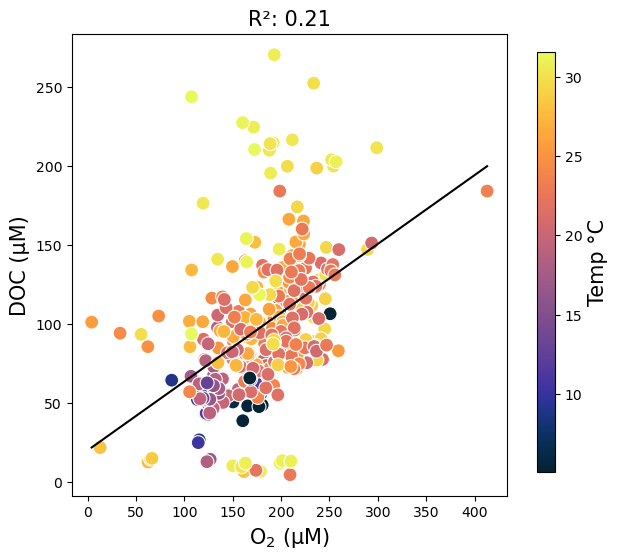

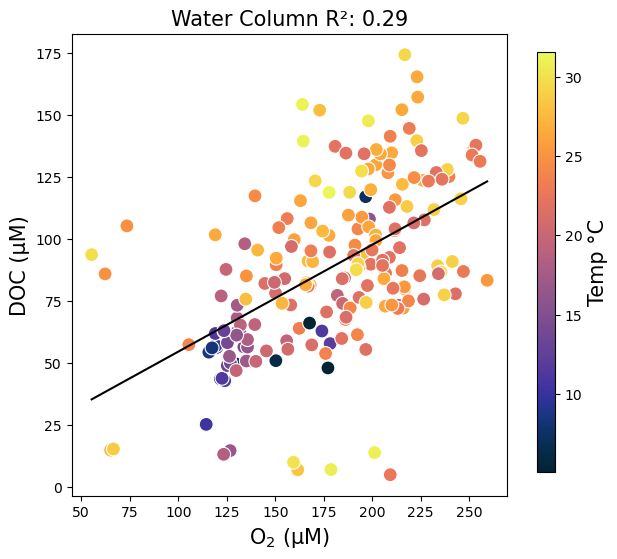

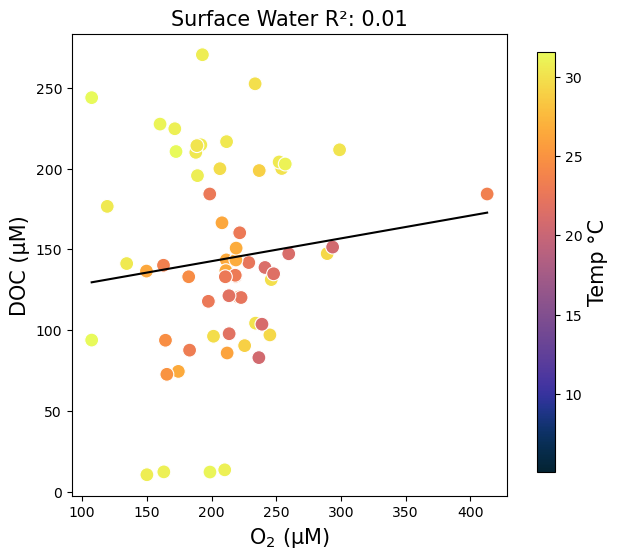

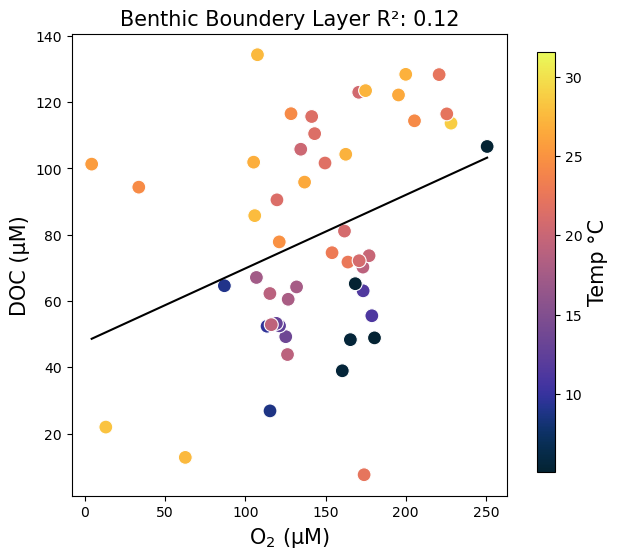

In [24]:
x_var = 'ox'
y_var = 'NPOC_uM'

x_var_lab = 'O$_2$ (µM)'
y_var_lab = 'DOC (µM)'


z_var = 'temp'
z_var_lab = 'Temp °C' 
z_var_color = cmo.thermal

titel = ""
save_name = 'ox_temp_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'ox_temp_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'ox_temp_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'ox_temp_bbl'
xyplotcolor(data_wc_bbl)

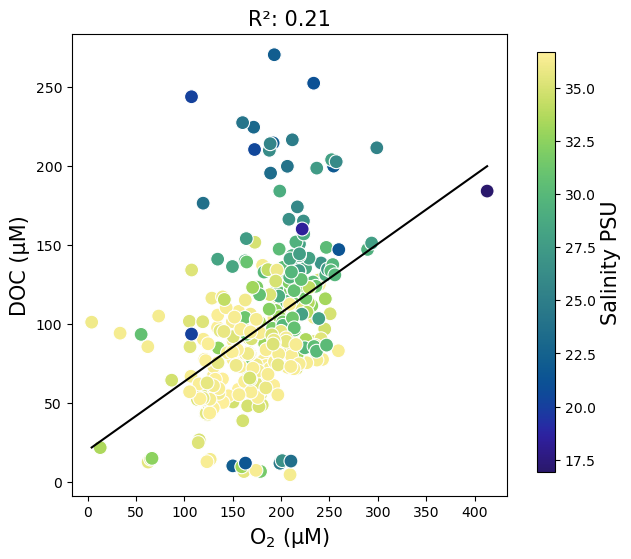

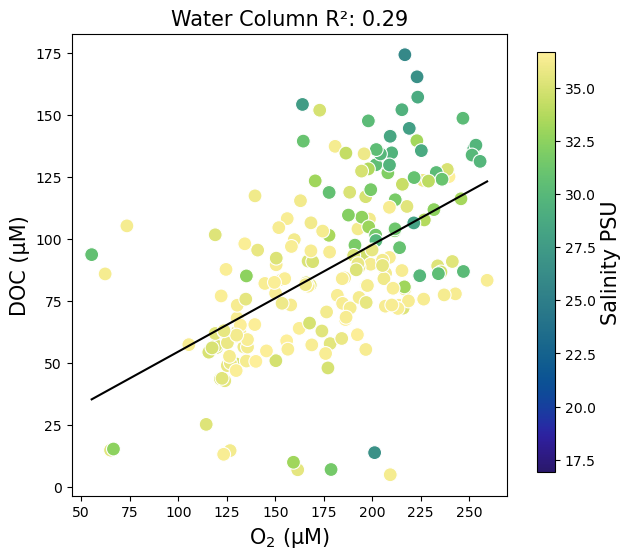

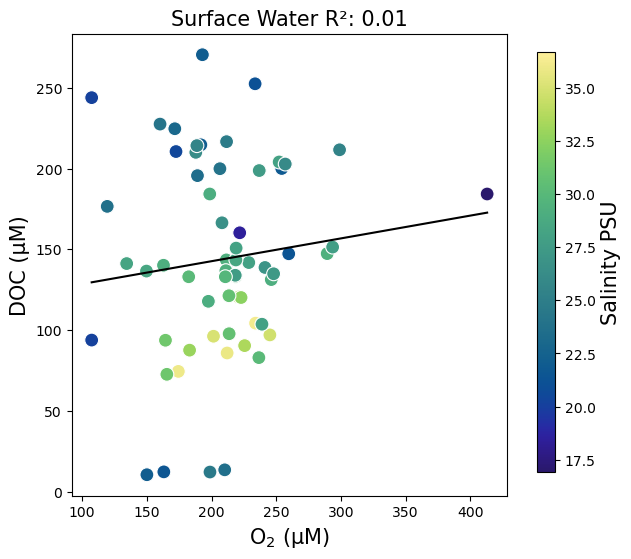

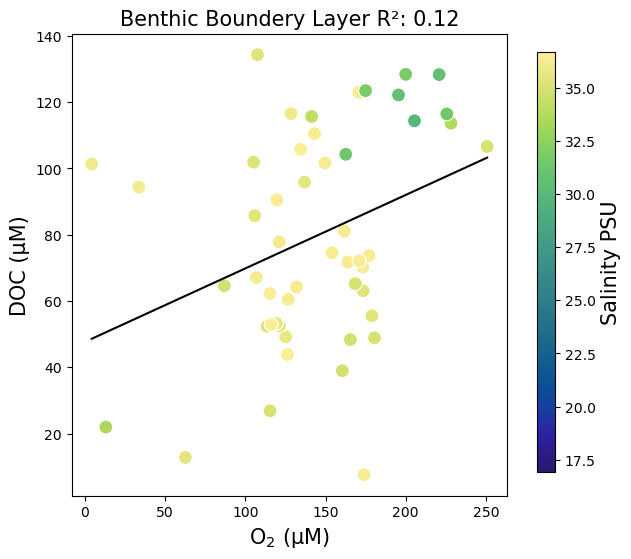

In [25]:
x_var = 'ox'
y_var = 'NPOC_uM'

x_var_lab = 'O$_2$ (µM)'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = ""
save_name = 'ox_sal_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'ox_sal_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'ox_sal_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'ox_sal_bbl'
xyplotcolor(data_wc_bbl)

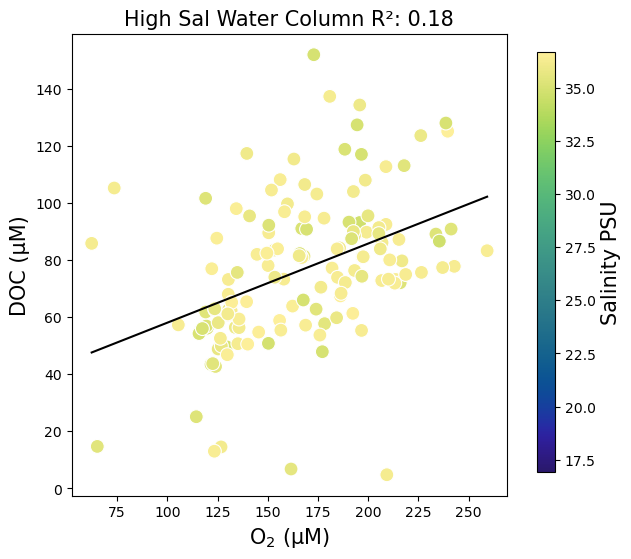

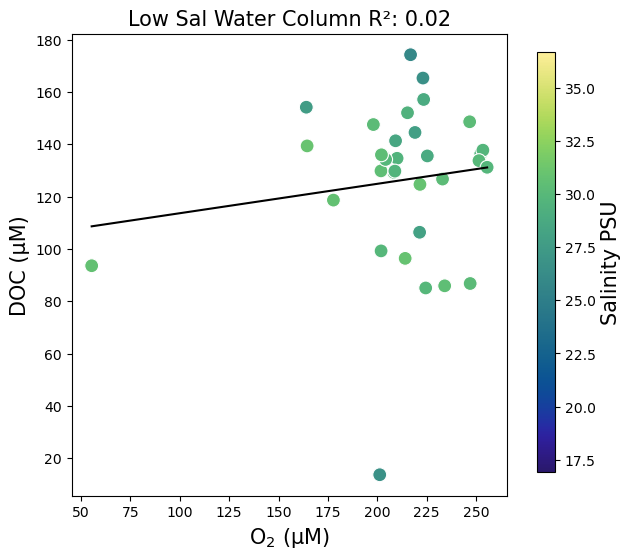

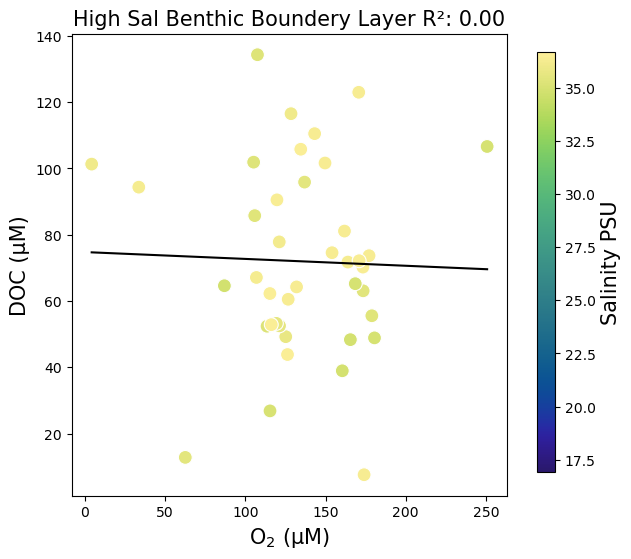

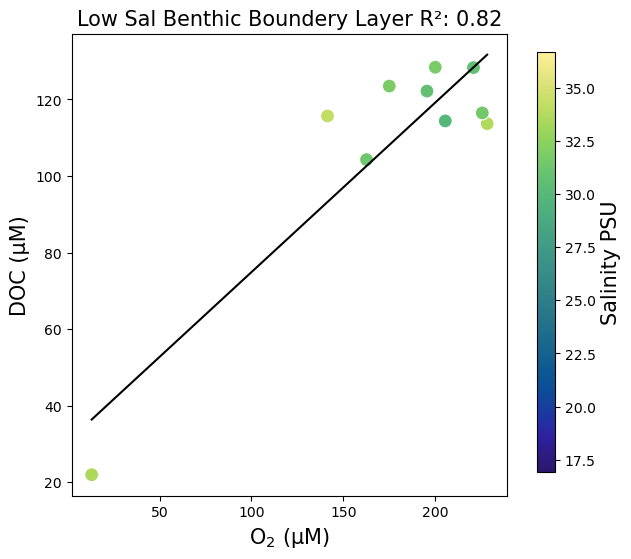

In [26]:
x_var = 'ox'
y_var = 'NPOC_uM'

x_var_lab = 'O$_2$ (µM)'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline


data_wc_hsal = data_wc[data_wc['sal'] >= 34.5]
data_wc_lsal = data_wc[data_wc['sal'] <= 31]

data_bbl_hsal = data_wc_bbl[data_wc_bbl['sal'] >= 34.5]
data_bbl_lsal = data_wc_bbl[data_wc_bbl['sal'] <= 34.5]


titel = "High Sal Water Column "
save_name = 'ox_highsal_wc'
xyplotcolor(data_wc_hsal)

titel = "Low Sal Water Column "
save_name = 'ox_lowsal_wc'
xyplotcolor(data_wc_lsal)

titel = "High Sal Benthic Boundery Layer "
save_name = 'ox_highsal_bbl'
xyplotcolor(data_bbl_hsal)

titel = "Low Sal Benthic Boundery Layer "
save_name = 'ox_lowsal_bbl'
xyplotcolor(data_bbl_lsal)

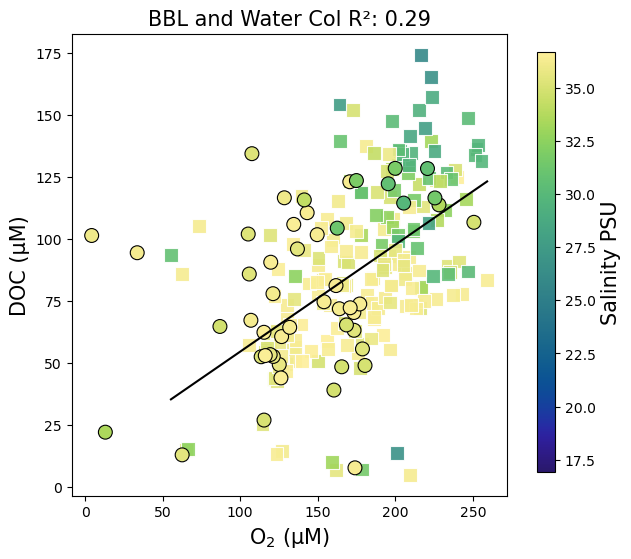

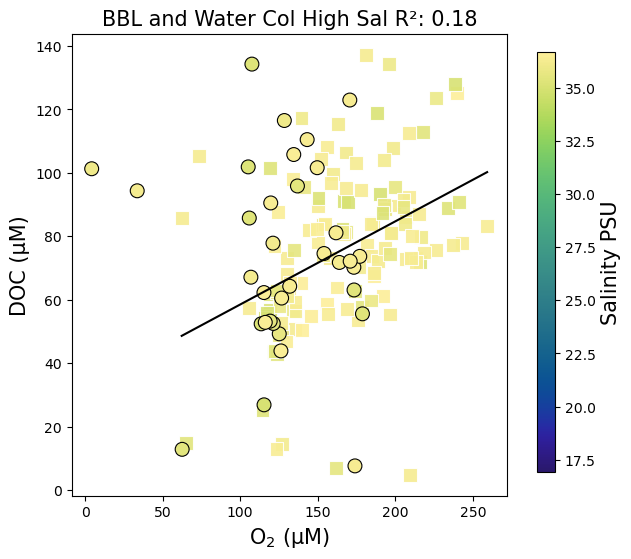

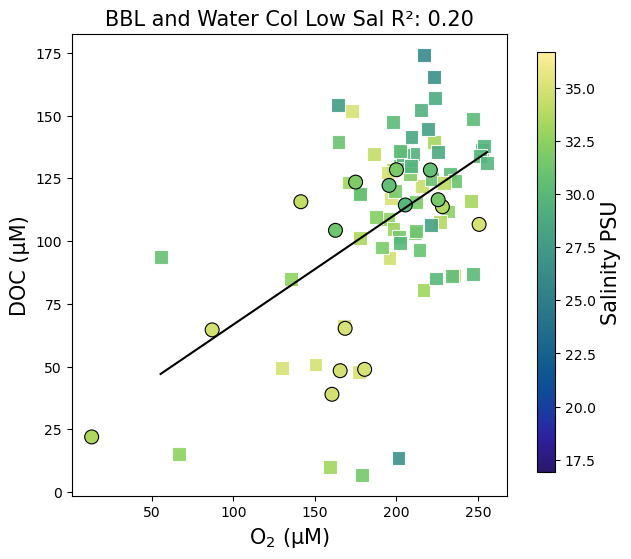

In [29]:
def xyplotcolor_2data(df, df2):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].min()
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    sub2 = df2.dropna(subset=[x_var, y_var])
    data2 = sub2[[x_var, y_var, z_var]]
    colors2 = data2[z_var].astype(float)
    X2 = data2[[x_var]]
    y2 = data2[y_var]
    
    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color,marker ="s", s=100, alpha = .9, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    sns.scatterplot(x=x_var, y=y_var, c=colors2, cmap=z_var_color, s=100, data=data2, edgecolor = 'black', ax=axes, legend=False, vmin=vmin, vmax=vmax)

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    


data_wc_hsal = data_wc[data_wc['sal'] >= 35]
data_wc_lsal = data_wc[data_wc['sal'] <= 35]

data_bbl_hsal = data_wc_bbl[data_wc_bbl['sal'] >= 35]
data_bbl_lsal = data_wc_bbl[data_wc_bbl['sal'] <= 35]


    
x_var = 'ox'
y_var = 'NPOC_uM'

x_var_lab = 'O$_2$ (µM)'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline


titel = "BBL and Water Col "
save_name = 'ox_sal_wc_and_bbl'
xyplotcolor_2data(data_wc, data_wc_bbl)


titel = "BBL and Water Col High Sal "
save_name = 'ox_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal)


titel = "BBL and Water Col Low Sal "
save_name = 'ox_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_lsal, data_bbl_lsal)


In [ ]:

    
x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline


titel = "BBL and Water Col "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc, data_wc_bbl)


titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal)


titel = "BBL and Water Col Low Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_lsal, data_bbl_lsal)


x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = "High PSU Benthic Boundery Layer "
save_name = 'aou_hsal_bbl'
xyplotcolor(data_bbl_hsal)
titel = "Low PSU Benthic Boundery Layer "
save_name = 'aou_lsal_bbl'
xyplotcolor(data_bbl_lsal)

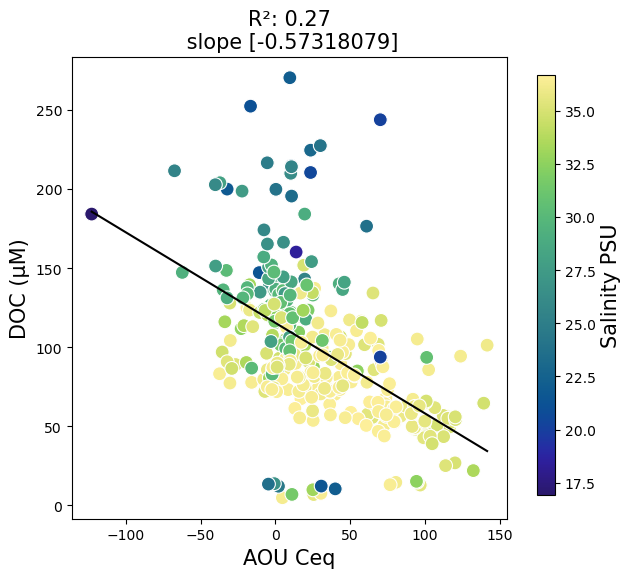

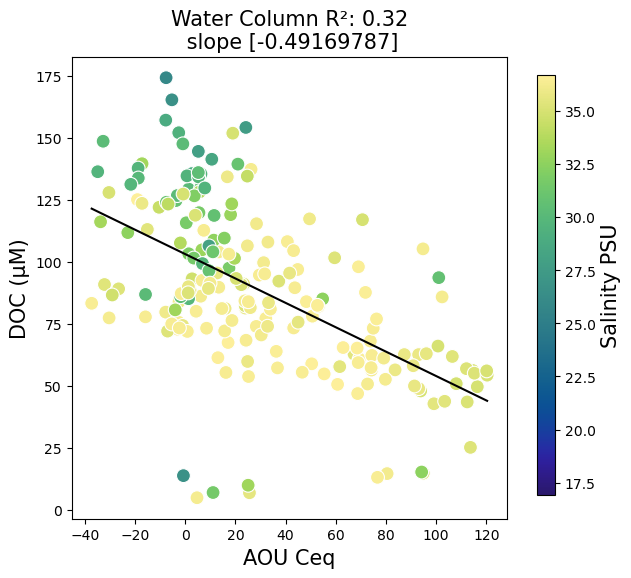

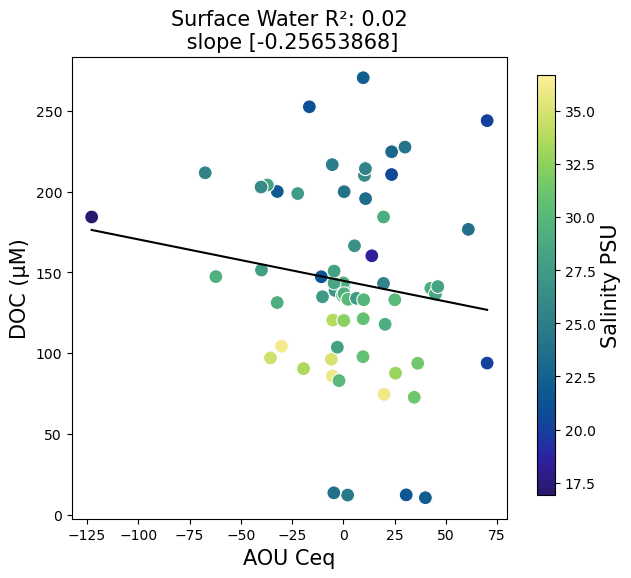

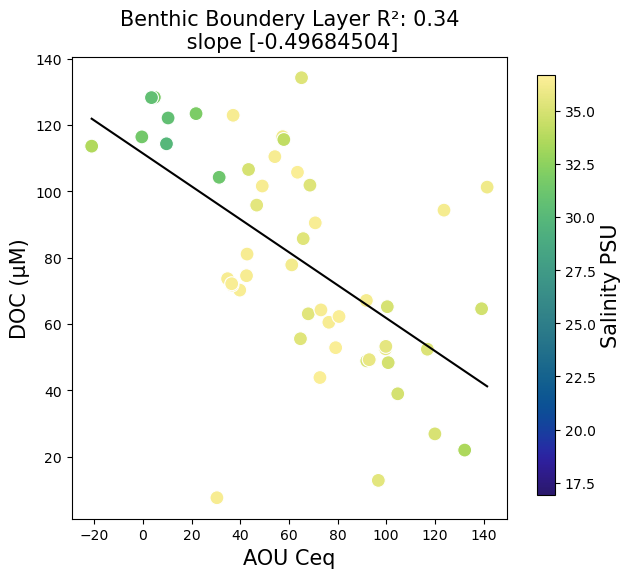

In [37]:
def xyplotcolor_Ceq(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].min()
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    intercept = model.intercept_
    slope = model.coef_

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}' + '\n'+ f' slope {slope}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    
    
x_var = 'aou-ceq'
y_var = 'NPOC_uM'

x_var_lab = 'AOU Ceq'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = ""
save_name = 'aou_temp_all'
xyplotcolor_Ceq(data_wc_all)
titel = "Water Column "
save_name = 'aou_temp_wc'
xyplotcolor_Ceq(data_wc)
titel = "Surface Water "
save_name = 'aou_temp_surf'
xyplotcolor_Ceq(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'aou_temp_bbl'
xyplotcolor_Ceq(data_wc_bbl)

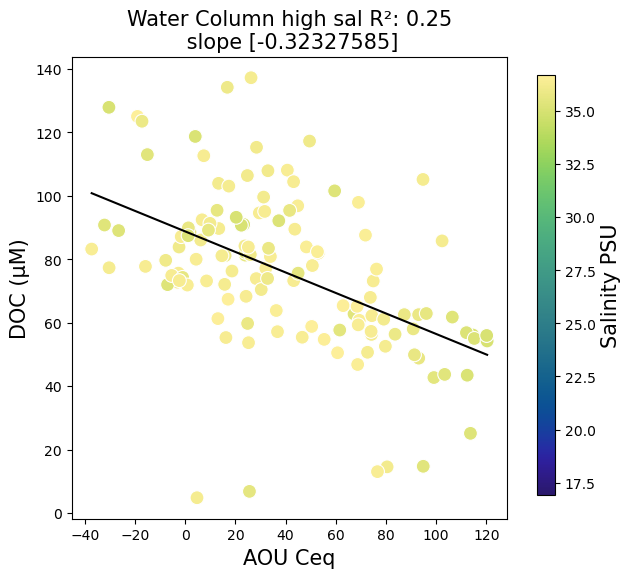

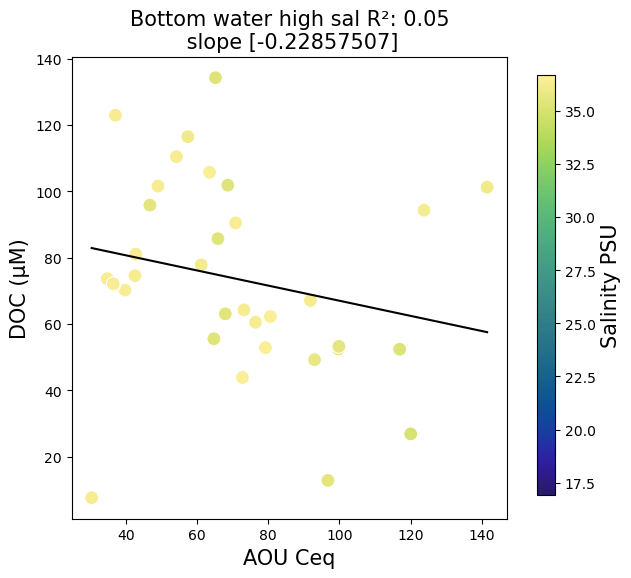

In [38]:
x_var = 'aou-ceq'
y_var = 'NPOC_uM'

x_var_lab = 'AOU Ceq'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = "Water Column high sal "
save_name = 'aou_temp_all'
xyplotcolor_Ceq(data_wc_hsal)

titel = "Bottom water high sal "
save_name = 'aou_temp_wc'
xyplotcolor_Ceq(data_bbl_hsal)




In [42]:
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.deming import Deming


# Assuming you have your data X and y

x_var = data_wc_hsal['aou-ceq']
y_var = data_wc_hsal['NPOC_uM']

# Add constant term to the independent variable
X_with_const = sm.add_constant(x_var)

# Fit Deming regression model
deming_model = Deming(y_var, X_with_const)
result = deming_model.fit()

# Print model summary
print(result.summary())

ModuleNotFoundError: No module named 'statsmodels.regression.deming'

In [ ]:
import numpy as np
from deming import DemingRegression

# Assuming you have your data x_var and y_var

# Initialize and fit Deming regression model
deming_model = DemingRegression()
deming_model.fit(x_var, y_var)

# Get the coefficients
intercept = deming_model.intercept_
slope = deming_model.coef_

print("Intercept:", intercept)
print("Slope:", slope)

In [ ]:
x_var = 'temp'
y_var = 'NPOC_uM'

x_var_lab = 'Temp °C'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = ""
save_name = 'temp_sal_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'temp_sal_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'temp_sal_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'temp_sal_bbl'
xyplotcolor(data_wc_bbl)

In [ ]:
x_var = 'sal' 
y_var = 'NPOC_uM'

x_var_lab = 'Salinity PSU'
y_var_lab = 'DOC (µM)'

z_var = 'temp'
z_var_lab = 'Temp °C' 
z_var_color = cmo.thermal

titel = ""
save_name = 'sal_temp_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'sal_temp_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'sal_temp_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'sal_temp_bbl'
xyplotcolor(data_wc_bbl)

In [ ]:
x_var = 'Depth'
y_var = 'NPOC_uM'

x_var_lab = 'Depth M'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = ""
save_name = 'depth_sal_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'depth_sal_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'depth_sal_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'depth_sal_bbl'
xyplotcolor(data_wc_bbl)

x_var = 'Depth'
y_var = 'NPOC_uM'

x_var_lab = 'Depth M'
y_var_lab = 'DOC (µM)'

z_var = 'temp'
z_var_lab = 'Temp °C' 
z_var_color = cmo.thermal

titel = ""
save_name = 'depth_temp_all'
xyplotcolor(data_wc_all)
titel = "Water Column "
save_name = 'depth_temp_wc'
xyplotcolor(data_wc)
titel = "Surface Water "
save_name = 'depth_temp_surf'
xyplotcolor(data_wc_surf)
titel = "Benthic Boundery Layer "
save_name = 'depth_temp_bbl'
xyplotcolor(data_wc_bbl)

data_wc.columns

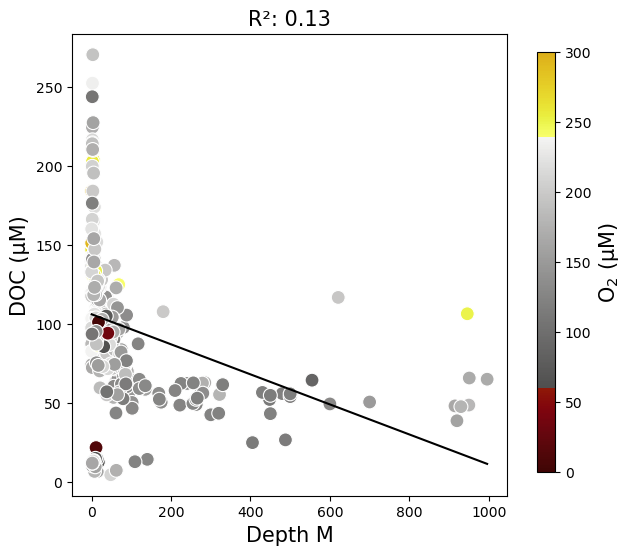

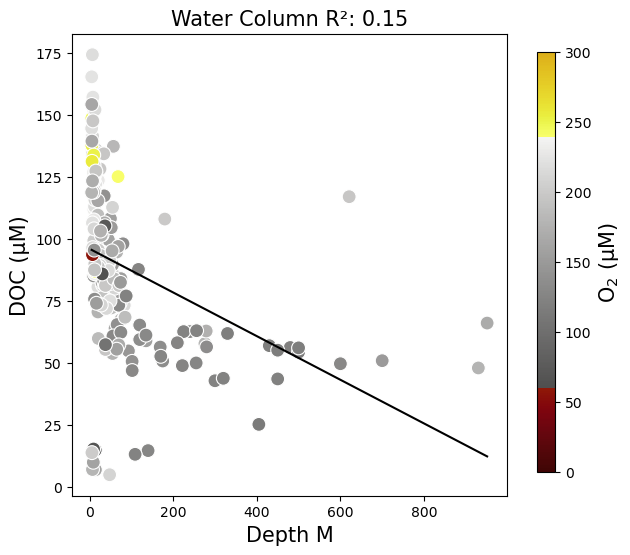

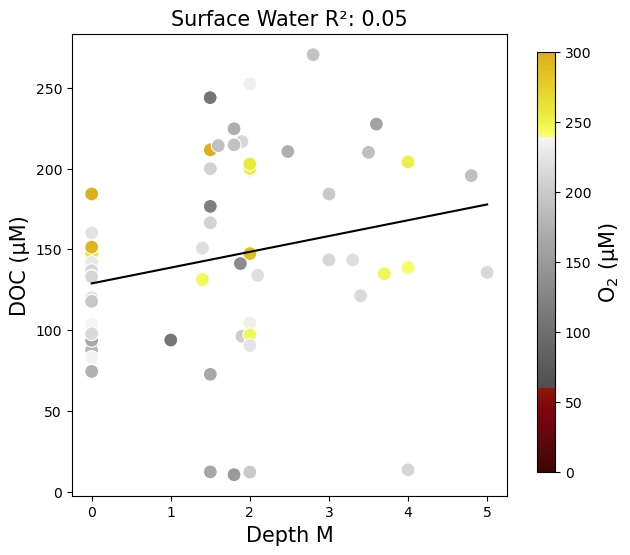

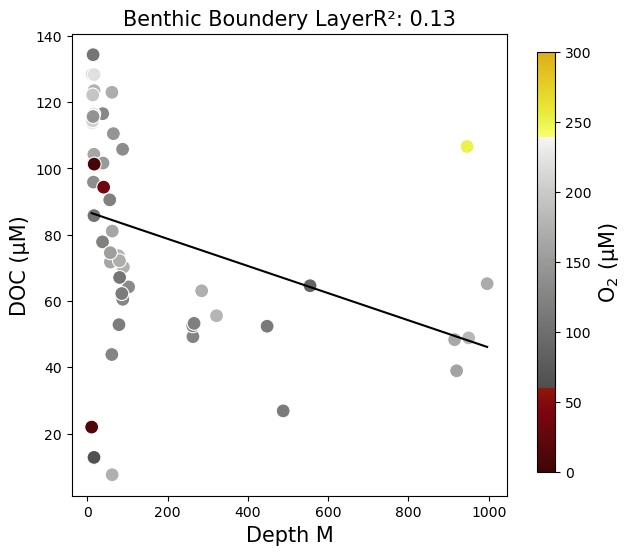

In [30]:
def xyplotcolor_oxy(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = 0
    vmax = 300

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()


x_var = 'Depth'
y_var = 'NPOC_uM'

x_var_lab = 'Depth M'
y_var_lab = 'DOC (µM)'

z_var = 'ox'
z_var_lab = 'O$_2$ (µM)'
z_var_color = cmo.oxy

titel = ""
save_name = 'depth_ox_all'
xyplotcolor_oxy(data_wc_all)
titel = "Water Column "
save_name = 'depth_ox_wc'
xyplotcolor_oxy(data_wc)
titel = "Surface Water "
save_name = 'depth_ox_surf'
xyplotcolor_oxy(data_wc_surf)
titel = "Benthic Boundery Layer"
save_name = 'depth_ox_bbl'
xyplotcolor_oxy(data_wc_bbl)

In [ ]:

x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ox'
z_var_lab = 'O$_2$ (µM)'
z_var_color = cmo.oxy

titel = "High PSU Benthic Boundery Layer "
save_name = 'aou_ox_hsal_bbl'
xyplotcolor_oxy(data_bbl_hsal)
titel = "Low PSU Benthic Boundery Layer "
save_name = 'aou_ox_lsal_bbl'
xyplotcolor_oxy(data_bbl_lsal)

In [ ]:
x_var = 'temp'
y_var = 'NPOC_uM'

x_var_lab = 'Temp °C'
y_var_lab = 'DOC (µM)'

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

data_wc_low_o2 = data_wc_all[data_wc_all['ox'] <= 60]
data_wc_high_o2 = data_wc_all[data_wc_all['ox'] >= 260]
data_wc_typical_o2 = data_wc_all[data_wc_all['ox'] <= 260]
data_wc_typical_o2 = data_wc_typical_o2[data_wc_typical_o2['ox'] >= 60]

titel = "High O$_2$ (µM) "
save_name = 'temp_sal_o2_high'
xyplotcolor(data_wc_high_o2)
titel = "Low O$_2$ (µM) "
save_name = 'temp_sal_o2_low'
xyplotcolor(data_wc_low_o2)
titel = "Typical O$_2$ (µM) "
save_name = 'temp_sal_o2_typical'
xyplotcolor(data_wc_typical_o2)

In [ ]:
x_var = 'sal'
y_var = 'temp' 

x_var_lab = 'Salinity PSU'
y_var_lab = 'Temp °C' 

z_var = 'sal'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

z_var = 'ox'
z_var_lab = 'O$_2$ (µM)'
z_var_color = cmo.oxy

titel = "Benthic Boundery Layer "
save_name = 'sal_temp_ox_bbl'
xyplotcolor_oxy(data_wc_bbl)

x_var = 'sal'
y_var = 'temp' 

x_var_lab = 'Salinity PSU'
y_var_lab = 'Temp °C' 

z_var = 'NPOC_uM'
z_var_lab = 'DOC (µM)'
z_var_color = cmo.matter

titel = "Benthic Boundery Layer "
save_name = 'sal_temp_doc_bbl'
xyplotcolor(data_wc_bbl)


x_var = 'ox'
y_var = 'temp' 

x_var_lab = 'O$_2$ (µM)'
y_var_lab = 'Temp °C' 

z_var = 'NPOC_uM'
z_var_lab = 'DOC (µM)'
z_var_color = cmo.matter

titel = "Benthic Boundery Layer "
save_name = 'ox_temp_doc_bbl'
xyplotcolor(data_wc_bbl)

x_var = 'ox'
y_var = 'sal' 

x_var_lab = 'O$_2$ (µM)'
y_var_lab = 'Salinity PSU' 

z_var = 'NPOC_uM'
z_var_lab = 'DOC (µM)'
z_var_color = cmo.matter

titel = "Benthic Boundery Layer "
save_name = 'ox_sal_doc_bbl'
xyplotcolor(data_wc_bbl)


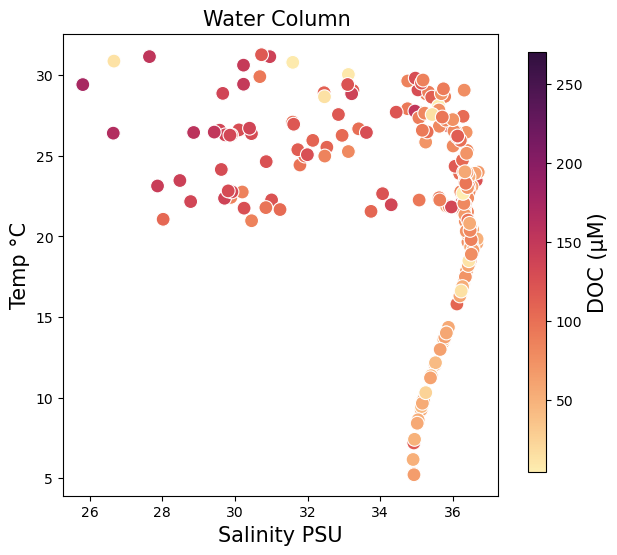

In [31]:
def xyplotcolor_noline(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data_wc_all[z_var].min()
    vmax = data_wc_all[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    #sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel, size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
x_var = 'sal'
y_var = 'temp' 

x_var_lab = 'Salinity PSU'
y_var_lab = 'Temp °C' 

z_var = 'NPOC_uM'
z_var_lab = 'DOC (µM)'
z_var_color = cmo.matter

titel = "Water Column "
save_name = 'sal_temp_doc_wc'
xyplotcolor_noline(data_wc)

In [ ]:
df.columns

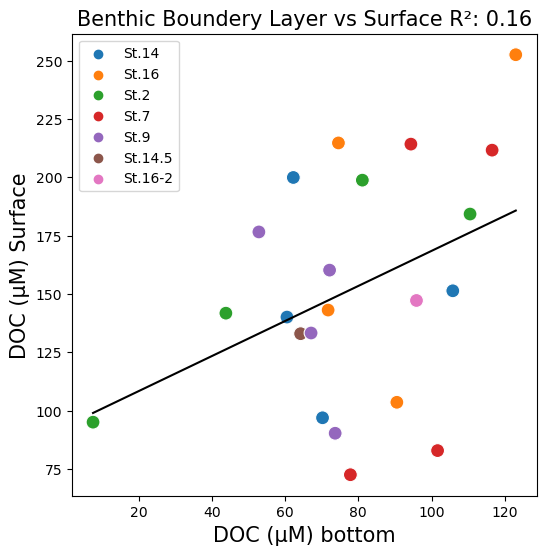

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def xyplotcolor_topbot(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, 'station']]  # 'station' column represents the categories
    station_categories = data['station'].unique()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, hue='station', palette='tab10', s=100, data=data, ax=axes)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

# Example variables
x_var = 'NPOC_uM'
y_var = 'NPOC_uM_surf' 
x_var_lab = 'DOC (µM) bottom'
y_var_lab = 'DOC (µM) Surface' 
titel = "Benthic Boundery Layer vs Surface "
save_name = 'doc_surf_bbl'

df2 = df[df['Pressure_dbar_bottom'] <= 200]
df2 = df2[df2['longitude_surface'] >= -90]


# Example usage
xyplotcolor_topbot(df2)


In [ ]:
df2

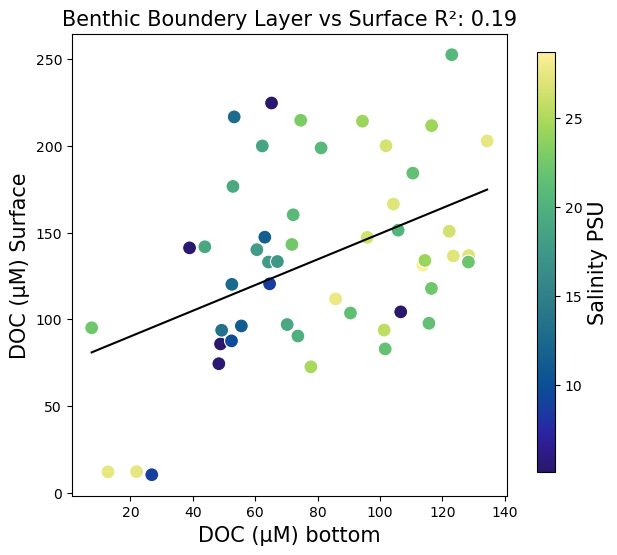

In [33]:
def xyplotcolor_topbot(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = df[z_var].min()
    vmax = df[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

x_var = 'NPOC_uM'
y_var = 'NPOC_uM_surf' 

x_var_lab = 'DOC (µM) bottom'
y_var_lab = 'DOC (µM) Surface' 

z_var = 'temp_bottom'
z_var_lab = 'Salinity PSU'
z_var_color = cmo.haline

titel = "Benthic Boundery Layer vs Surface "
save_name = 'doc_surf_bbl'
xyplotcolor_topbot(df)

In [ ]:
data_bottom_water

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\3011763413.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\3011763413.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\3011763413.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\hmlbr\AppD

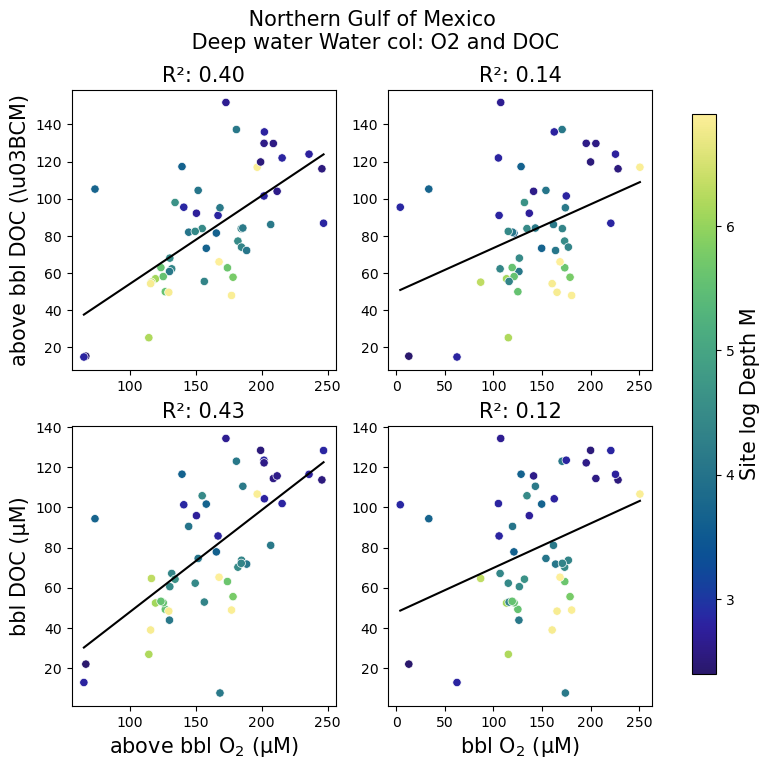

In [34]:
def cor_plot_stn_sum_2(data_frame, title):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    
    # Set up the color bar limits
    vmin = data_frame['Depth_ctd_lower_log'].min()
    vmax = data_frame['Depth_ctd_lower_log'].max()

    # Loop through the subplots
    for i, x_var in enumerate(['ox_uM_upper', 'ox_uM_lower']):
        for j, y_var in enumerate(['NPOC_uM_upper', 'NPOC_uM_lower']):
            # Prepare the data for the subplot
            data = data_frame[[x_var, y_var, 'Depth_ctd_lower_log']]
            data.dropna(inplace=True)
            X = data[[x_var]]
            y = data[y_var]
            colors = data['Depth_ctd_lower_log'].astype(float)

            # Fit a linear regression model to the data
            model = LinearRegression()
            model.fit(X, y)
            score = model.score(X, y)

            # Plot the data and regression line
            ax = axes[j, i]
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.haline, vmin=vmin, vmax=vmax, legend=False)
            sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

            # Set the axis labels and title
            if j == 1:
                ax.set_xlabel(x_var.replace('ox_uM_lower', 'bbl O$_2$ (\u03BCM)').replace('ox_uM_upper', 'above bbl O$_2$ (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('TN_uM', 'dissolved N (\u03BCM)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('NPOC_uM_lower', 'bbl DOC (\u03BCM)').replace('NPOC_uM_upper', r'above bbl DOC (\u03BCM)'), size = 15)
            else: 
                ax.set_ylabel("")
            ax.set_title(f'R\u00B2: {score:.2f}', size = 15)
            #ax.set_ylim([data[y_var].max(), data[y_var].max()])
            #ax.set_xlim([data[x_var].min(), data[x_var].max()])

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.haline, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel('Site log Depth M', size = 15)
        
    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    #plt.tight_layout()
    plt.show()

cor_plot_stn_sum_2(data_bottom_water, f' Northern Gulf of Mexico \n Deep water Water col: O2 and DOC')



In [ ]:
x_var = 'ox_uM_lower'
y_var = 'NPOC_uM_lower'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

model = LinearRegression()
sub = data_bottom_water.dropna(subset=[x_var, y_var])
data = sub[[x_var, y_var, 'O2_change_per_meter']]
colors = data['O2_change_per_meter'].astype(float)

vmin = data['O2_change_per_meter'].min()
vmax = data['O2_change_per_meter'].min()*-1

X = data[[x_var]]
y = data[y_var]
model.fit(X, y)
score = model.score(X, y)

sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=cmo.balance, s=100, data=data, ax=axes, legend=False)
sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

axes.set_xlabel(x_var.replace('ox_uM_lower', 'bbl O$_2$ (\u03BCM)'), size=15)
axes.set_ylabel(y_var.replace('NPOC_uM_lower', 'bbl DOC (µM)'), size=15)

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.balance, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('O$_2$ Decrease (m$^{-1}$)', size=15)

# Show the plot
plt.show()


In [ ]:
x_var = 'ox_uM_lower'
y_var = 'NPOC_uM_lower'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

model = LinearRegression()
sub = data_bottom_water.dropna(subset=[x_var, y_var])
data = sub[[x_var, y_var, 'DOC_change_per_meter']]
colors = data['DOC_change_per_meter'].astype(float)

vmin = data['DOC_change_per_meter'].min()
vmax = data['DOC_change_per_meter'].min()*-1

X = data[[x_var]]
y = data[y_var]
model.fit(X, y)
score = model.score(X, y)

sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=cmo.balance, s=100, data=data, ax=axes, legend=False)
sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

axes.set_xlabel(x_var.replace('ox_uM_lower', 'bbl O$_2$ (\u03BCM)'), size=15)
axes.set_ylabel(y_var.replace('NPOC_uM_lower', 'bbl DOC (µM)'), size=15)

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.balance, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('DOC (µM) Decrease (m$^{-1}$)', size=15)

# Show the plot
plt.show()


In [ ]:
df_low_doc = data_wc[data_wc['NPOC_uM'] <= 25]
df_low_doc

In [ ]:
df_low_doc = data_wc_bbl[data_wc_bbl['NPOC_uM'] <= 25]
df_low_doc

In [ ]:
# Define the formula for linear regression

formula = 'NPOC_uM ~ ox * sal * temp'
df_OM = data_wc[data_wc['NPOC_uM'] >= 25]

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_OM).fit()
print(model.summary())

# Residuals
residuals = model.resid

# Plot 1: Residuals vs Fitted values
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Plot 2: QQ Plot
sm.qqplot(residuals, line ='45')
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Plot 3: Scale-Location Plot
sqrt_abs_standardized_resid = abs(residuals**0.5)
sns.regplot(x=model.fittedvalues, y=sqrt_abs_standardized_resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location Plot')
plt.xlabel('Fitted values')
plt.ylabel('Square root of absolute standardized residuals')
plt.show()

# Plot 4: Residuals vs Leverage Plot (Cook's distance)
sm.graphics.plot_leverage_resid2(model)
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.show()

# Make predictions
predicted = model.predict(df_OM)

# Insert predictions back to dataframe
df_OM['NPOC_pred'] = predicted

# Plot
plt.scatter(df_OM['NPOC_uM'], predicted)
plt.xlabel(r'Actual DOC (µM)')
plt.ylabel('Predicted  DOC (µM)')
plt.title('')
plt.plot([df_OM['NPOC_uM'].min(), df_OM['NPOC_uM'].max()], 
         [df_OM['NPOC_uM'].min(), df_OM['NPOC_uM'].max()], 'r--')
plt.show()

# Extract coefficients and corresponding variables
coefficients = model.params
variables = coefficients.index.tolist()



# Print out the equation nicely
print("NPOC_uM =", end=" ")
for i, (variable, coefficient) in enumerate(zip(variables, coefficients)):
    if i != 0:
        print("+", end=" ")
    print(f"{coefficient:.4f} * {variable}", end=" ")
print()

In [ ]:
data_wc['NPOC_uM_pred'] = 1666.0944 + -8.7393 * data_wc['ox'] + -48.8126 * data_wc['sal'] + 0.2657 * data_wc['ox']* data_wc['sal'] + -59.4246 * data_wc['temp']  + 0.3749 * data_wc['ox'] * data_wc['temp'] + 1.8456 * data_wc['sal'] * data_wc['temp'] + -0.0113 * data_wc['ox']*data_wc['sal'] * data_wc['temp']  


#Plot
plt.scatter(data_wc['NPOC_uM'], data_wc['NPOC_uM_pred'])
plt.xlabel(r'Actual DOC (µM)')
plt.ylabel('Predicted  DOC (µM)')
plt.title('')
plt.plot([data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 
         [data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 'r--')
plt.show()

In [ ]:
data_wc_bbl['NPOC_uM_pred'] = 1666.0944 + -8.7393 * data_wc_bbl['ox'] + -48.8126 * data_wc_bbl['sal'] + 0.2657 * data_wc_bbl['ox']* data_wc_bbl['sal'] + -59.4246 * data_wc_bbl['temp']  + 0.3749 * data_wc_bbl['ox'] * data_wc_bbl['temp'] + 1.8456 * data_wc_bbl['sal'] * data_wc_bbl['temp'] + -0.0113 * data_wc_bbl['ox']*data_wc_bbl['sal'] * data_wc_bbl['temp']  


#Plot
plt.scatter(data_wc_bbl['NPOC_uM'], data_wc_bbl['NPOC_uM_pred'])
plt.xlabel(r'Actual DOC (µM)')
plt.ylabel('Predicted  DOC (µM)')
plt.title('')
plt.plot([data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 
         [data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 'r--')
plt.show()

In [ ]:
data_wc_bbl['code'] = data_wc_bbl['Location'] + '_' + data_wc_bbl['Campaign']
data_wc_bbl.index = data_wc_bbl['code']

flux_doc_pw = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_doc_pw.csv', sep=',', index_col=0)
flux_doc_pw_join = flux_doc_pw['pw_flux_doc']

data_wc_bbl['pw_flux_doc'] = flux_doc_pw_join

data_wc_bbl_plot = data_wc_bbl[data_wc_bbl['pw_flux_doc'] >= 0]
data_wc_bbl_plot = data_wc_bbl_plot[data_wc_bbl_plot['pw_flux_doc'] <= 50]


#Plot
plt.scatter(data_wc_bbl_plot['NPOC_uM'], data_wc_bbl_plot['NPOC_uM_pred'], c = data_wc_bbl_plot['pw_flux_doc'])
plt.xlabel(r'Actual DOC (µM)')
plt.ylabel('Predicted  DOC (µM)')
plt.title('')
plt.plot([data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 
         [data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 'r--')
plt.show()


In [ ]:
# Plot
scatter = plt.scatter(data_wc_bbl_plot['NPOC_uM'], data_wc_bbl_plot['NPOC_uM_pred'], c=data_wc_bbl_plot['pw_flux_doc'])
plt.xlabel(r'Actual DOC (µM)')
plt.ylabel('Predicted DOC (µM)')
plt.title('')
plt.plot([data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 
         [data_wc['NPOC_uM'].min(), data_wc['NPOC_uM'].max()], 'r--')
plt.colorbar(scatter, label='DOC Flux')
plt.show()


In [ ]:
# Plot
scatter = plt.scatter(data_wc_bbl_plot['NPOC_uM'], data_wc_bbl_plot['pw_flux_doc'])
plt.xlabel(r' DOC (µM)')
plt.ylabel(' DOC flux (µM)')
plt.title('')
plt.show()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\2663927713.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bbl_hsal['code'] = data_bbl_hsal['Location'] + '_' + data_bbl_hsal['Campaign']
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\2663927713.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bbl_lsal['code'] = data_bbl_lsal['Location'] + '_' + data_bbl_lsal['Campaign']
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_14868\2663927713.py:44: SettingWithCopyWarning: 
A value is trying to be

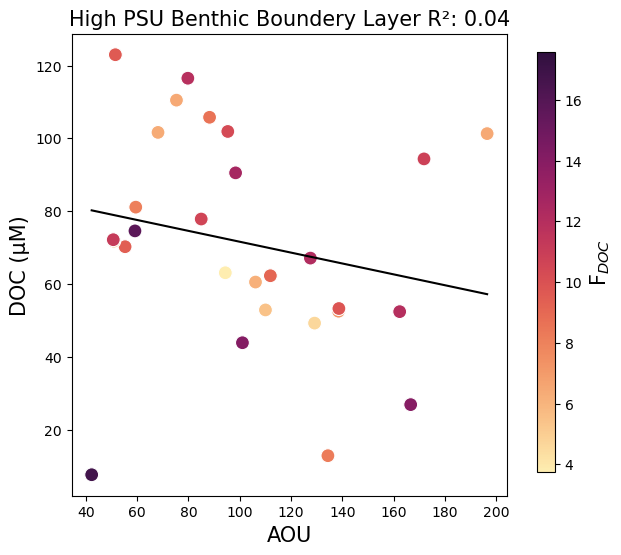

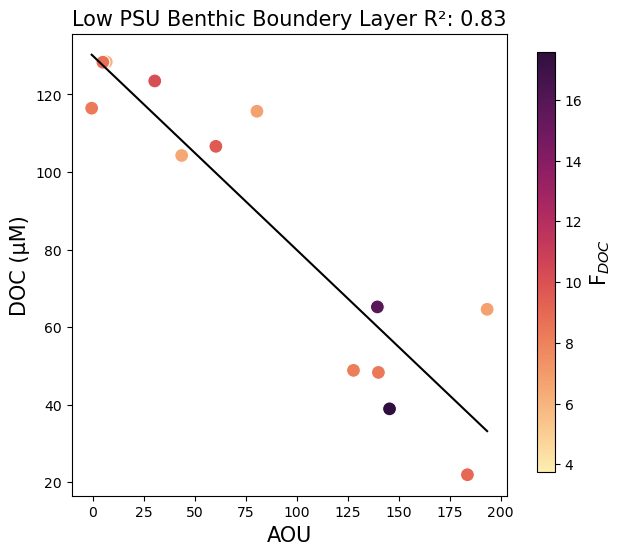

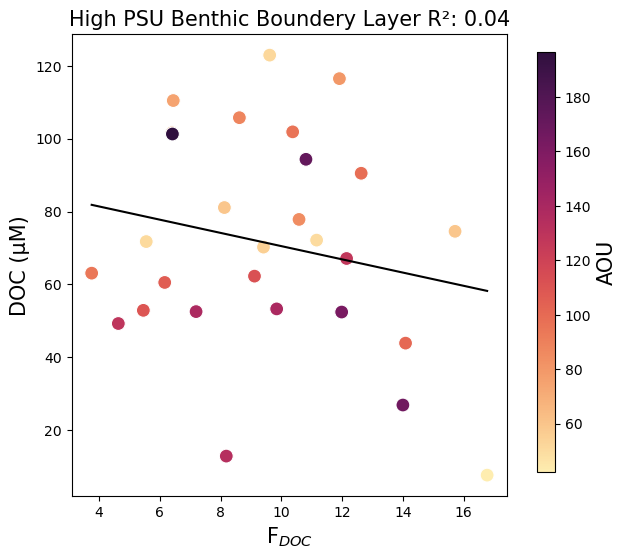

In [35]:
def xyplotcolor_flux(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = flux_doc_pw_join[flux_doc_pw_join < 50].min()
    vmax = flux_doc_pw_join[flux_doc_pw_join < 50].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

data_bbl_hsal['code'] = data_bbl_hsal['Location'] + '_' + data_bbl_hsal['Campaign']
data_bbl_lsal['code'] = data_bbl_lsal['Location'] + '_' + data_bbl_lsal['Campaign']

data_bbl_hsal.index = data_bbl_hsal['code']
data_bbl_lsal.index = data_bbl_lsal['code']


flux_doc_pw = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/Flux_doc_pw.csv', sep=',', index_col=0)
flux_doc_pw_join = flux_doc_pw['pw_flux_doc']

data_bbl_hsal['pw_flux_doc'] = flux_doc_pw_join
data_bbl_lsal['pw_flux_doc'] = flux_doc_pw_join

data_bbl_hsal_plot = data_bbl_hsal[data_bbl_hsal['pw_flux_doc'] >= 0]
data_bbl_hsal_plot = data_bbl_hsal_plot[data_bbl_hsal_plot['pw_flux_doc'] <= 50]

data_bbl_lsal_plot = data_bbl_lsal[data_bbl_lsal['pw_flux_doc'] >= 0]
data_bbl_lsal_plot = data_bbl_lsal_plot[data_bbl_lsal_plot['pw_flux_doc'] <= 50]

x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'pw_flux_doc'
z_var_lab = 'F$_{DOC}$'
z_var_color = cmo.matter

titel = "High PSU Benthic Boundery Layer "
save_name = 'aou_hsal_bbl_doc'
xyplotcolor_flux(data_bbl_hsal_plot)
titel = "Low PSU Benthic Boundery Layer "
save_name = 'aou_lsal_bbl_doc'
xyplotcolor_flux(data_bbl_lsal_plot)


def xyplotcolor_flux2(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data[z_var].min()
    vmax = data[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

z_var = 'aou'
y_var = 'NPOC_uM'

z_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

x_var = 'pw_flux_doc'
x_var_lab = 'F$_{DOC}$'
z_var_color = cmo.matter

titel = "High PSU Benthic Boundery Layer "
save_name = 'aou_hsal_bbl_doc'
xyplotcolor_flux2(data_bbl_hsal_plot)

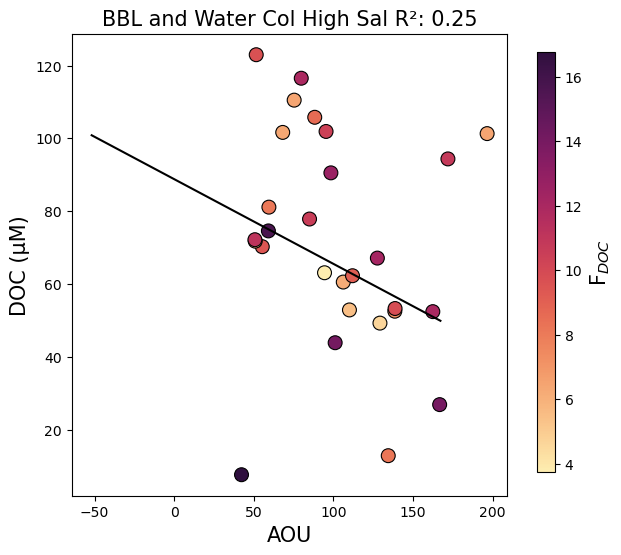

In [36]:
def xyplotcolor_2data(df, df2):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var]]
    #colors = data[z_var].astype(float)

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    sub2 = df2.dropna(subset=[x_var, y_var])
    data2 = sub2[[x_var, y_var, z_var]]
    colors2 = data2[z_var].astype(float)
    X2 = data2[[x_var]]
    y2 = data2[y_var]
    
    vmin = data2[z_var].min()
    vmax = data2[z_var].max()
    
    #sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color,marker ="s", s=100, alpha = .9, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    sns.scatterplot(x=x_var, y=y_var, c=colors2, cmap=z_var_color, s=100, data=data2, edgecolor = 'black', ax=axes, legend=False, vmin=vmin, vmax=vmax)

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    

data_wc_hsal = data_wc[data_wc['sal'] >= 35]
data_wc_lsal = data_wc[data_wc['sal'] <= 35]

data_bbl_hsal = data_wc_bbl[data_wc_bbl['sal'] >= 35]
data_bbl_lsal = data_wc_bbl[data_wc_bbl['sal'] <= 35]


    
x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'pw_flux_doc'
z_var_lab = 'F$_{DOC}$'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)


In [ ]:
fe_stocks = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/Iron_stocks.csv', sep=',', index_col=0)
fe_stocks

In [ ]:
data_bottom_water.index = data_bottom_water['code']
data_bottom_water

In [ ]:
data_bbl_hsal_plot.columns

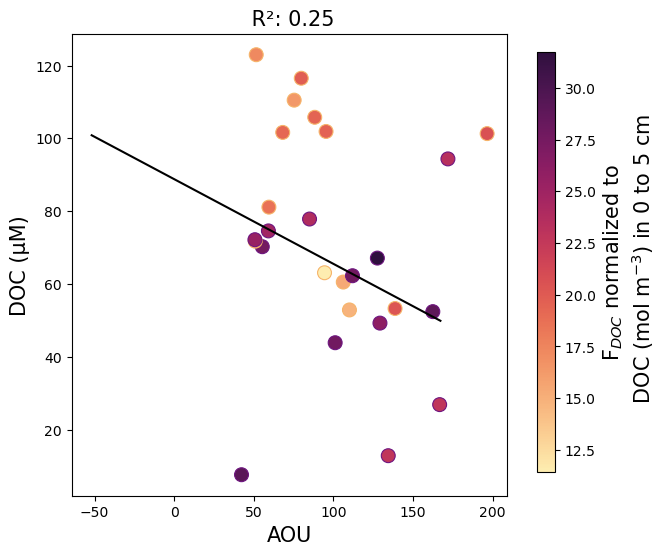

KeyError: ['percent_doc_resp']

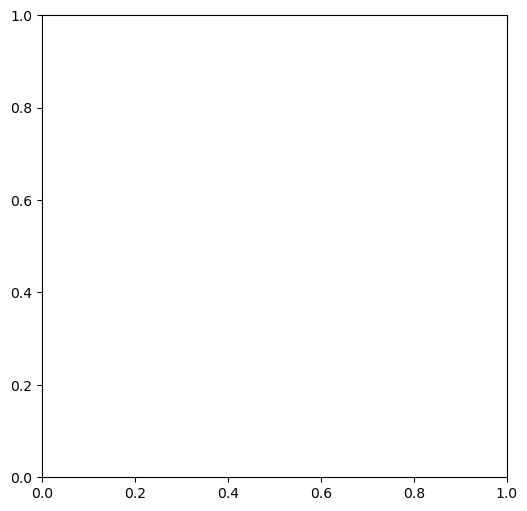

In [47]:
fe_stocks = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/Iron_stocks.csv', sep=',', index_col=0)
fe_stocks_join = fe_stocks['fet_mol_per_m3_0_to_5cm']
data_bbl_hsal_plot['fet_mol_per_m3_0_to_5cm'] = fe_stocks_join
fe_stocks_join = fe_stocks['fe2_mol_per_m3_0_to_5cm']
data_bbl_hsal_plot['fe2_mol_per_m3_0_to_5cm'] = fe_stocks_join
fe_stocks_join = fe_stocks['fe3_mol_per_m3_0_to_5cm']
data_bbl_hsal_plot['fe3_mol_per_m3_0_to_5cm'] = fe_stocks_join
fe_stocks_join = fe_stocks['fet_mol_per_m3_0_to_25cm']
data_bbl_hsal_plot['fet_mol_per_m3_0_to_25cm'] = fe_stocks_join
fe_stocks_join = fe_stocks['fe2_mol_per_m3_0_to_25cm']
data_bbl_hsal_plot['fe2_mol_per_m3_0_to_25cm'] = fe_stocks_join
fe_stocks_join = fe_stocks['fe3_mol_per_m3_0_to_25cm']
data_bbl_hsal_plot['fe3_mol_per_m3_0_to_25cm'] = fe_stocks_join

doc_stocks = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/DOC_stocks.csv', sep=',', index_col=0)
doc_stocks_join = doc_stocks['doc_mol_per_m3_0_to_25cm']
data_bbl_hsal_plot['doc_mol_per_m3_0_to_25cm'] = doc_stocks_join
doc_stocks_join = doc_stocks['doc_mol_per_m3_0_to_5cm']
data_bbl_hsal_plot['doc_mol_per_m3_0_to_5cm'] = doc_stocks_join

doc_stocks = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/DOC_stocks.csv', sep=',', index_col=0)
doc_stocks_join = doc_stocks['doc_mol_per_m3_0_to_25cm']
data_bbl_lsal_plot['doc_mol_per_m3_0_to_25cm'] = doc_stocks_join
doc_stocks_join = doc_stocks['doc_mol_per_m3_0_to_5cm']
data_bbl_lsal_plot['doc_mol_per_m3_0_to_5cm'] = doc_stocks_join

ncs_stocks = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/NCS_stocks.csv', sep=',', index_col=0)
ncs_stocks['OC_mol_per_m3_0_to_5cm'] = ncs_stocks['OCg_5cm_deep/M2'] * 12
ncs_stocks_join = ncs_stocks['OC_mol_per_m3_0_to_5cm']
data_bbl_hsal_plot['OC_mol_per_m3_0_to_5cm'] = ncs_stocks_join


n = 0.29
data_bbl_hsal_plot['Cox'] = (data_bbl_hsal_plot['pw_flux_doc'] / 0.36) 
data_bbl_hsal_plot['Cox'] = data_bbl_hsal_plot['Cox'].apply(lambda x: x ** (1/n))

data_bbl_hsal_plot['percent_doc_resp'] = (data_bbl_hsal_plot['NPOC_uM'] / data_bbl_hsal_plot['aou']*0.72) * 100

data_bbl_hsal_plot['ratio_flux_2_stock'] = data_bbl_hsal_plot['pw_flux_doc'] / data_bbl_hsal_plot['doc_mol_per_m3_0_to_5cm']
data_bbl_hsal_plot['ratio_pw_flux_doc_2_cox'] = data_bbl_hsal_plot['pw_flux_doc'] / data_bbl_hsal_plot['Cox']

data_bbl_hsal_plot['ratio_doc_2_fet'] = data_bbl_hsal_plot['doc_mol_per_m3_0_to_5cm'] / data_bbl_hsal_plot['fet_mol_per_m3_0_to_25cm']
data_bbl_hsal_plot['ratio_oc_2_fet'] = data_bbl_hsal_plot['OC_mol_per_m3_0_to_5cm'] / data_bbl_hsal_plot['fet_mol_per_m3_0_to_5cm']


def xyplotcolor_2data(df, df2):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var]]
    #colors = data[z_var].astype(float)

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    sub2 = df2.dropna(subset=[x_var, y_var])
    data2 = sub2[[x_var, y_var, z_var]]
    colors2 = data2[z_var].astype(float)
    X2 = data2[[x_var]]
    y2 = data2[y_var]
    
    vmin = data2[z_var].min()
    vmax = data2[z_var].max()
    
    #sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color,marker ="s", s=100, alpha = .9, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    edgecolor = np.where(data2[z_var] <= data2[z_var].mean(), '#F6B46A', '#6E1580')

    
    sns.scatterplot(x=x_var, y=y_var, c=colors2, cmap=z_var_color, s=100, data=data2, edgecolor = edgecolor, ax=axes, legend=False, vmin=vmin, vmax=vmax)

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    

data_wc_hsal = data_wc[data_wc['sal'] >= 35]
data_wc_lsal = data_wc[data_wc['sal'] <= 35]

data_bbl_hsal = data_wc_bbl[data_wc_bbl['sal'] >= 35]
data_bbl_lsal = data_wc_bbl[data_wc_bbl['sal'] <= 35]



x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ratio_flux_2_stock'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'
z_var_color = cmo.matter

titel = " "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)

x_var = 'aou-ceq'
y_var = 'NPOC_uM'

x_var_lab = 'AOU Carbon Equveletns'
y_var_lab = 'DOC (µM)'

z_var = 'ratio_flux_2_stock'
z_var_lab = 'ratio_flux_2_stock'
z_var_color = cmo.matter

titel = " "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)


In [56]:
data_wc_hsal.columns

Index(['Press', 'ox', 'temp', 'sal', 'NPOC_uM', 'Depth', 'Campaign',
       'Location', 'Ts', 'density_kg_m3', 'density_kg_l', 'ox_umol_kg',
       'ox_sat', 'aou', 'group', 'aou-ceq'],
      dtype='object')

In [ ]:
data_bbl_hsal_plot['fet_mol_per_m3_0_to_25cm'] #fet_mol_per_m3_0_to_5cm

In [ ]:

data_bbl_hsal_plot_highflux = data_bbl_hsal_plot[data_bbl_hsal_plot['ratio_flux_2_stock'] >= data_bbl_hsal_plot['ratio_flux_2_stock'].mean()]
data_bbl_hsal_plot_lowflux = data_bbl_hsal_plot[data_bbl_hsal_plot['ratio_flux_2_stock'] <= data_bbl_hsal_plot['ratio_flux_2_stock'].mean()]

In [ ]:
def xyplotcolor_flux3(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)
    
    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    vmin = data[z_var].min()
    vmax = 20

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    #plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    
x_var = 'percent_doc_resp'
y_var = 'ratio_flux_2_stock'

x_var_lab = 'percent_doc_resp'
y_var_lab = 'ratio_flux_2_stock'

z_var = 'ratio_doc_2_fet'
z_var_lab = 'ratio_doc_2_fet'
z_var_color = cmo.thermal

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'

titel = "BBL and Water Col High Sal "
xyplotcolor_flux3(data_bbl_hsal_plot)

titel = "BBL and Water Col High Sal Low Flux"
xyplotcolor_flux3(data_bbl_hsal_plot_lowflux)

titel = "BBL and Water Col High Sal High Flux"
xyplotcolor_flux3(data_bbl_hsal_plot_highflux)

In [ ]:
x_var = 'ratio_pw_flux_doc_2_cox'
y_var = 'fe2_mol_per_m3_0_to_5cm'

x_var_lab = 'ratio_pw_flux_doc_2_cox'
y_var_lab = 'fe2_mol_per_m3_0_to_5cm'

z_var = 'percent_doc_resp'
z_var_lab = 'percent_doc_resp'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux2(data_bbl_hsal_plot)

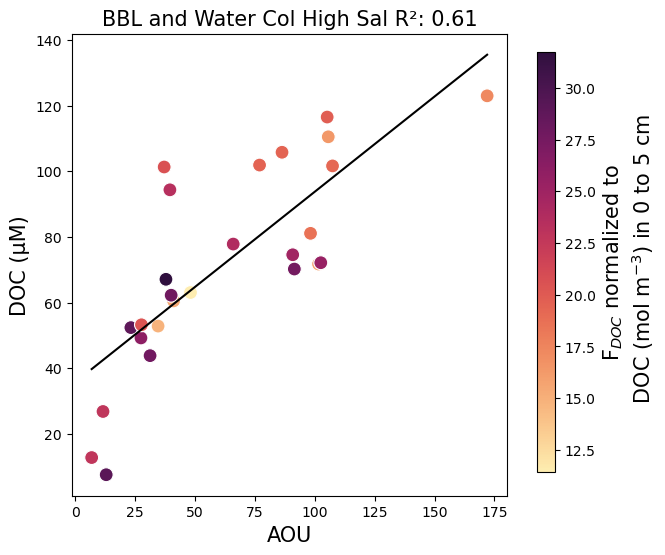

In [50]:

    
x_var = 'percent_doc_resp'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ratio_flux_2_stock'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux2(data_bbl_hsal_plot)

In [ ]:

x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ratio_flux_2_stock'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'
z_var_color = cmo.balance

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)


In [ ]:
data_bbl_hsal_plot.columns

In [ ]:
# Define the formula for linear regression

Val = 'pw_flux_doc'

formula = 'pw_flux_doc ~ doc_mol_per_m3_0_to_5cm + percent_doc_resp' 
#percent_doc_resp ' #r=0.683 all ponits significant 
#NPOC_uM ' #r=0.693 CI 95 did not work 
#aou ' #r=0.619


df_OM = data_bbl_hsal_plot

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_OM).fit()
print(model.summary())

# Residuals
residuals = model.resid

# Plot 1: Residuals vs Fitted values
sns.residplot(x=model.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

# Plot 2: QQ Plot
sm.qqplot(residuals, line ='45')
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

# Plot 3: Scale-Location Plot
sqrt_abs_standardized_resid = abs(residuals**0.5)
sns.regplot(x=model.fittedvalues, y=sqrt_abs_standardized_resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Scale-Location Plot')
plt.xlabel('Fitted values')
plt.ylabel('Square root of absolute standardized residuals')
plt.show()

# Plot 4: Residuals vs Leverage Plot (Cook's distance)
sm.graphics.plot_leverage_resid2(model)
plt.title('Residuals vs Leverage')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.show()

# Make predictions
predicted = model.predict(df_OM)

# Insert predictions back to dataframe
df_OM['pred'] = predicted

# Plot
plt.scatter(df_OM[Val], predicted)
plt.xlabel(r'Actual F$_{DOC}$ ')
plt.ylabel('Predicted  F$_{DOC}$  ')
plt.title('')
plt.plot([df_OM[Val].min(), df_OM[Val].max()], 
         [df_OM[Val].min(), df_OM[Val].max()], 'r--')
plt.show()

# Extract coefficients and corresponding variables
coefficients = model.params
variables = coefficients.index.tolist()


# Print out the equation nicely
print("pw_flux_doc =", end=" ")
for i, (variable, coefficient) in enumerate(zip(variables, coefficients)):
    if i != 0:
        print("+", end=" ")
    print(f"{coefficient:.4f} * {variable}", end=" ")
print()


In [ ]:
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the formula for linear regression
Val = 'pw_flux_doc'
formula = 'pw_flux_doc ~ doc_mol_per_m3_0_to_5cm + percent_doc_resp' 

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_OM).fit()
print(model.summary())

# Make predictions
predicted = model.predict(df_OM)

# Calculate residuals
residuals = df_OM[Val] - predicted

# Calculate effect sizes (Cohen's d)
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.var(x) + (ny - 1) * np.var(y)) / dof)

# Calculate effect size for each predictor variable
for var in model.params.index[1:]:
    effect_size = cohen_d(df_OM[var], predicted)
    print(f"Effect size (Cohen's d) for {var}: {effect_size}")


In [ ]:
# Calculate correlation between predictors and response
corr_doc = df_OM['doc_mol_per_m3_0_to_5cm'].corr(df_OM['pw_flux_doc'])
corr_percent = df_OM['percent_doc_resp'].corr(df_OM['pw_flux_doc'])

# Calculate proportion of variability explained
prop_var_explained_doc = corr_doc ** 2
prop_var_explained_percent = corr_percent ** 2

print("Proportion of variability in pw_flux_doc explained by doc_mol_per_m3_0_to_5cm:", prop_var_explained_doc)
print("Proportion of variability in pw_flux_doc explained by percent_doc_resp:", prop_var_explained_percent)

print("")

# Calculate squared semi-partial correlation coefficient for doc_mol_per_m3_0_to_5cm
semipartial_corr_doc = model.pvalues['doc_mol_per_m3_0_to_5cm'] / (model.pvalues['doc_mol_per_m3_0_to_5cm'] + model.resid.std() ** 2)

# Calculate squared semi-partial correlation coefficient for percent_doc_resp
semipartial_corr_percent = model.pvalues['percent_doc_resp'] / (model.pvalues['percent_doc_resp'] + model.resid.std() ** 2)

print("Squared semi-partial correlation coefficient for doc_mol_per_m3_0_to_5cm:", semipartial_corr_doc)
print("Squared semi-partial correlation coefficient for percent_doc_resp:", semipartial_corr_percent)


In [ ]:
STOP

In [ ]:
data_bottom_water

In [ ]:
delta_DOC_join = data_bottom_water['DOC_change_per_meter'] 
delta_O2_join = data_bottom_water['O2_change_per_meter'] 

data_bbl_hsal_plot['DOC_change_per_meter'] = delta_DOC_join
data_bbl_hsal_plot['O2_change_per_meter'] = delta_O2_join



x_var = 'aou'
y_var = 'ratio'

x_var_lab = 'AOU'
y_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'

z_var = 'DOC_change_per_meter'
z_var_lab = 'DOC_change_per_meter'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux2(data_bbl_hsal_plot)



x_var = 'aou'
y_var = 'ratio'

x_var_lab = 'AOU'
y_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'

z_var = 'O2_change_per_meter'
z_var_lab = 'O2_change_per_meter'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_flux2(data_bbl_hsal_plot)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def tricolor_cmap(min_color, mid_color, max_color, min_value, max_value, mid_value):
    cmap = LinearSegmentedColormap.from_list('tricolor', [min_color, mid_color, max_color])
    norm = plt.Normalize(min_value, max_value)
    return cmap, norm

# Example values and colors
min_value = 0
mid_value = 75
max_value = 100
min_color = 'blue'
mid_color = 'green'
max_color = 'red'

# Create the custom colormap
cmap, norm = tricolor_cmap(min_color, mid_color, max_color, min_value, max_value, mid_value)

# Create a sample plot with the color bar
x = np.linspace(min_value, max_value, 100)
y = np.sin(x)

plt.scatter(x, y, c=x, cmap=cmap, norm=norm)
plt.colorbar(label='Color Bar')
plt.show()


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

#orig_cmap = cmo.balance
cmap_bal_shift = shiftedColorMap(orig_cmap, midpoint=0.59, name='cma_bal_shitsmk2')
#shrunk_cmap = shiftedColorMap(orig_cmap, start=0.15, midpoint=0.75, stop=0.85, name='shrunk')


def xyplotcolor_2data(df, df2):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var]]
    #colors = data[z_var].astype(float)

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    sub2 = df2.dropna(subset=[x_var, y_var])
    data2 = sub2[[x_var, y_var, z_var]]
    colors2 = data2[z_var].astype(float)
    X2 = data2[[x_var]]
    y2 = data2[y_var]
    
    vmin = 5
    vmax = 35
    
    #sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color,marker ="s", s=100, alpha = .9, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    sns.scatterplot(x=x_var, y=y_var, c=colors2, cmap=z_var_color, s=100, data=data2, edgecolor = 'black', ax=axes, legend=False, vmin=vmin, vmax=vmax)

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()
    

data_wc_hsal = data_wc[data_wc['sal'] >= 35]
data_wc_lsal = data_wc[data_wc['sal'] <= 35]

data_bbl_hsal = data_wc_bbl[data_wc_bbl['sal'] >= 35]
data_bbl_lsal = data_wc_bbl[data_wc_bbl['sal'] <= 35]


    
x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ratio'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'
z_var_color = cmap_bal_shift

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)



In [ ]:
data_bbl_hsal_plot['ratio']

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def tricolor_palette(min_color, mid_color, max_color, min_value, max_value, mid_value, n=256):
    lower_range = np.linspace(min_value, mid_value, n//2)
    upper_range = np.linspace(mid_value, max_value, n//2)
    palette = np.concatenate([
        sns.color_palette([min_color, mid_color], n_colors=n//2),
        sns.color_palette([mid_color, max_color], n_colors=n//2)
    ])
    values = np.concatenate([lower_range, upper_range])
    return palette, values

# Example values and colors
min_value = 0
mid_value = 25
max_value = 40
min_color = 'blue'
mid_color = 'green'
max_color = 'red'

# Call the tricolor_palette function to get the palette and values
palette, values = tricolor_palette(min_color, mid_color, max_color, min_value, max_value, mid_value)

def xyplotcolor_2data(df, df2):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var]]

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    sub2 = df2.dropna(subset=[x_var, y_var])
    data2 = sub2[[x_var, y_var, z_var]]
    colors2 = data2[z_var].astype(float)
    X2 = data2[[x_var]]
    y2 = data2[y_var]
    
    vmin = 5
    vmax = 35
    
    # Use the custom palette and values
    sns.scatterplot(x=x_var, y=y_var, palette=palette, hue=z_var, data=data2, edgecolor='black', ax=axes, legend=False)
    
    # Plot regression line
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size=15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.show()

# Replace x_var, y_var, z_var, x_var_lab, y_var_lab, z_var_lab, and titel with your variables.

x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ratio'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)

In [ ]:
ncs_stocks = pd.read_csv('../Dissertation_projects/Data/Stats_data_sets/NCS_stocks.csv', sep=',', index_col=0)
ncs_stocks_join = ncs_stocks['OCg_5cm_deep/M2']
data_bbl_hsal_plot['OCg_5cm_deep_m3'] = ncs_stocks_join

data_bbl_hsal_plot['ratio'] = data_bbl_hsal_plot['pw_flux_doc'] / data_bbl_hsal_plot['OCg_5cm_deep_m3']

x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'ratio'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)

ncs_stocks

In [ ]:
data_bbl_hsal_plot['fe2_mol_per_m3_0_to_5cm']

In [ ]:
def xyplotcolor_stocks(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data[z_var].min()
    vmax = data[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel, size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

data_bbl_hsal_plot['ratio'] = data_bbl_hsal_plot['pw_flux_doc'] / data_bbl_hsal_plot['doc_mol_per_m3_0_to_5cm']


x_var = 'fe2_mol_per_m3_0_to_5cm'
y_var = 'NPOC_uM'

x_var_lab = 'fe2_mol_per_m3_0_to_5cm'
y_var_lab = 'DOC (µM)'

z_var = 'ratio'
z_var_lab = 'F$_{DOC}$ normalized to \n DOC (mol m$^{-3}$) in 0 to 5 cm'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_stocks(data_bbl_hsal_plot)

In [ ]:
data_bbl_hsal_plot['flux_z'] = (data_bbl_hsal_plot['pw_flux_doc'] - data_bbl_hsal_plot['pw_flux_doc'].mean() )/ data_bbl_hsal_plot['pw_flux_doc'].std()
data_bbl_hsal_plot['fe2_z'] = (data_bbl_hsal_plot['fe2_mol_per_m3_0_to_5cm'] - data_bbl_hsal_plot['fe2_mol_per_m3_0_to_5cm'].mean() )/ data_bbl_hsal_plot['fe2_mol_per_m3_0_to_5cm'].std()

    
x_var = 'aou'
y_var = 'NPOC_uM'

x_var_lab = 'AOU'
y_var_lab = 'DOC (µM)'

z_var = 'flux_z'
z_var_lab = 'flux_z'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)

z_var = 'fe2_z'
z_var_lab = 'fe2_z'
z_var_color = cmo.matter

titel = "BBL and Water Col High Sal "
save_name = 'aou_sal_wc_and_bbl'
xyplotcolor_2data(data_wc_hsal, data_bbl_hsal_plot)


